# **GCExplainer**

This exercise goes step-by-step through the training of a Graph Convolutional Network (GCN) that performs the task of node classification in the Barabasi-Albert Shapes dataset. This dataset is first imported, then the GCN is trained and then the activation of each layer of the GCN is passed through several different dimensionality reduction functions. On the resulting 2D space, several clustering methods can be applied (in this exercise k-means, where k is specified by the user) that separate the possible concepts to which each node belongs to. After the clusters are learned, the five nodes that are nearest to the cluster centre are selected together with their neighbourhood (number of hops is defined by the user) and depicted. This shows the coherency of the concepts, those subgraphs are quite similar; a similarity which can also be quantified by the Graph Edit Distance (GED). Furthermore, a classifier (here: a decision tree) trained on the clustered nodes can provide a quantitative measure for the completeness of the explanation, provided that it has a sufficiently good performance.

This is an adaptation of the original GCExplainer code in the Github repository of Charlotte-Louise Magister: https://github.com/CharlotteMagister/GCExplainer. The paper that describes the GCExplainer is: https://arxiv.org/pdf/2107.11889.pdf.


In [ ]:
# Torch and PyGeometric installation for GPU -----------------------------------

!pip3 install torch torchvision torchaudio
!pip3 install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.2.0+cu121.html
!pip3 install torch_geometric
!pip3 install umap-learn
!pip3 install seaborn

Looking in links: https://data.pyg.org/whl/torch-2.2.0+cu121.html


In [ ]:
# Torch and PyGeometric installation for CPU -----------------------------------

!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
!pip3 install torch_geometric
!pip3 install umap-learn
!pip3 install seaborn

Looking in indexes: https://download.pytorch.org/whl/cpu
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 6.0 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=f8bde439889ee44424dc05c8c68444141e7e368ed78e82f806d33ee685361343
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn


In [ ]:
# [0.] Preparation and reproducibility ensurance -------------------------------
import random

import numpy as np
import torch

torch.manual_seed(0)
random.seed(0)
np.random.seed(0)



In the following code segment, one can change the number of clusters - that correspond to the number of assumed concepts in the datasets - and one can adapt the value of variable "k".

For the adaptation of the n-hop neighbourhood that will be presented in the plots of the explained nodes, the value of the variable "num_expansions" needs to be changed.



In [ ]:
################################################################################
# [1.] Import dataset, prepare train/test split ================================
################################################################################
import pandas as pd
from sklearn.model_selection import train_test_split
import torch_geometric
from torch_geometric.datasets import BAShapes

# [1.1.] Import the dataset BA-Shapes containing Barabasi-Albert graphs --------
dataset = BAShapes()
graph_ba_shapes = dataset[0]
graph_ba_shapes_labels = graph_ba_shapes.y.numpy()
graph_ba_shapes_nodes_nr = graph_ba_shapes_labels.shape[0]

model_type_name = "BA_Shapes_GCN"

# [1.2.] Define number of concepts/clusters with the variable "k" --------------
#        and the size of the hop-neighborhood around each explained node -------
#        with the variable "num_expansions" ------------------------------------
k = 6
num_expansions = 1  # only the 1-hop neighborhood of the node will be plotted --

training_set_proportion = 0.8     # Proportion of the training set -------------
num_hidden_units = 20             # Nr. of GCN hidden units --------------------
num_classes = 4                   # Nr. of possible classes of nodes -----------
lr = 0.001                        # Learning rate ------------------------------

# [1.3.] Split training and test set -------------------------------------------
graph_ba_shapes_labels_df = pd.DataFrame(data=graph_ba_shapes_labels)

y_train_df, y_test_df = train_test_split(graph_ba_shapes_labels_df,
                                         train_size=training_set_proportion,
                                         stratify=graph_ba_shapes_labels_df)

# [1.4.] Use the computed indexes of training and test set to
#        set the masks in the dataset ------------------------------------------
train_indexes_list = y_train_df.index.values.tolist()
test_indexes_list = y_test_df.index.values.tolist()

train_mask = [False]*graph_ba_shapes_nodes_nr
test_mask = [False]*graph_ba_shapes_nodes_nr
for train_index in train_indexes_list:
    train_mask[train_index] = True
for test_index in test_indexes_list:
    test_mask[test_index] = True

train_mask_torch = torch.tensor(train_mask, dtype=torch.bool)
test_mask_torch = torch.tensor(test_mask, dtype=torch.bool)

graph_ba_shapes.train_mask = train_mask_torch
graph_ba_shapes.test_mask = test_mask_torch


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'BAShapes' is deprecated, use 'datasets.ExplainerDataset' in combination with 'datasets.graph_generator.BAGraph' instead
  warnings.warn(out)


In [ ]:
################################################################################
# [2.] Graph Convolutional Network (GCN) for node classification ===============
################################################################################
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric
from torch_geometric.nn import GCNConv
from sklearn.metrics import balanced_accuracy_score

class BA_Shapes_GCN(nn.Module):

    def __init__(self, num_in_features: int,
                       num_hidden_units: int,
                       num_classes: int,
                       name: str) -> torch.Tensor:
        """
        Initialization of the GCN architecture; definition of the types
        of layers and their sizes

        :param num_in_features: Number of node's input features
        :param num_hidden_units: Number of hidden layer neurons
        (in the context of GNNs generally its the number of message passing
        combinations and aggregations)
        :param num_classes: Number of possible node's classes
        :param name: Name of created GCN

        """

        super(BA_Shapes_GCN, self).__init__()

        self.name = name

        # Definition of 4 convolutional layers ---------------------------------
        self.conv0 = GCNConv(num_in_features, num_hidden_units)
        self.conv1 = GCNConv(num_hidden_units, num_hidden_units)
        self.conv2 = GCNConv(num_hidden_units, num_hidden_units)
        self.conv3 = GCNConv(num_hidden_units, num_hidden_units)

        self.linear = nn.Linear(num_hidden_units, num_classes)

    def forward(self, x: torch.Tensor, edge_index: torch.Tensor) -> torch.Tensor:
        """
        Forward function of the GCN architecture

        :param x: The node features matrix
        :param edge_index: The matrix that contains all edges
        """

        x = self.conv0(x, edge_index)
        x = F.relu(x)

        x = self.conv1(x, edge_index)
        x = F.relu(x)

        x = self.conv2(x, edge_index)
        x = F.relu(x)

        x = self.conv3(x, edge_index)
        x = F.relu(x)

        x = self.linear(x)

        return F.log_softmax(x, dim=-1)

# Global variable that gathers the activations of all layers of the GCN --------
global activation_list
activation_list = {}

def get_activation(layer_descriptor: str):
    """
    Returns the activation of each layer

    :param layer_descriptor: Layer's descriptor (conv1, conv2, conv3, linear)
    """

    '''Learned from: https://discuss.pytorch.org/t/how-can-l-load-my-best-model-as-a-feature-extractor-evaluator/17254/6'''


    def hook(model, input: tuple, output: torch.Tensor):
        """
        "Hook" function that detaches the activation and inserts it in
        the global activation list.

        :param model: Model or layer type
        :param input: Input tuple passed of features matrix and edge matrix
        :param output: Ouput of the model or layer
        """

        activation_list[layer_descriptor] = output.detach()

    return hook

def register_hooks(model: BA_Shapes_GCN) -> BA_Shapes_GCN:
    """
    Register hooks to all layers of the model

    :@param model:
    """

    for name, m in model.named_modules():
        if isinstance(m, GCNConv):
            m.register_forward_hook(get_activation(f"{name}"))
        if isinstance(m, nn.Linear):
            m.register_forward_hook(get_activation(f"{name}"))

    return model


# [2.1.] Create the GCN --------------------------------------------------------
model = BA_Shapes_GCN(graph_ba_shapes["x"].shape[1],
                      num_hidden_units,
                      num_classes,
                      "BA-Shapes")

# Register the hooks on the created model --------------------------------------
model = register_hooks(model)

# Set the GCN training hyperparameters -----------------------------------------
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()


def train():
    """
    Training  method of the GCN for the training set
    It computes the metric for the training set data
    """

    model.train()
    optimizer.zero_grad()

    out = model(graph_ba_shapes.x, graph_ba_shapes.edge_index)

    loss = criterion(out[graph_ba_shapes.train_mask],
                     graph_ba_shapes.y[graph_ba_shapes.train_mask])
    loss.backward()
    optimizer.step()

    return loss


def test():
    """
    Testing method of the GCN for the test set
    It computes the metric for the test set data
    """

    model.eval()

    out = model(graph_ba_shapes.x, graph_ba_shapes.edge_index)
    pred = out.argmax(dim=1)

    balanced_acc = balanced_accuracy_score(
        graph_ba_shapes.y[graph_ba_shapes.test_mask].numpy(),
        pred[graph_ba_shapes.test_mask].numpy()
    )

    return balanced_acc


# [2.2.] Use the training set to train the model -------------------------------
for epoch in range(1, 301):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

# [2.3.] Use the test set to evaluate the model --------------------------------
test_acc = test()
print(f'Test set Balanced Accuracy: {test_acc:.4f}')
print("=======================================================================")


Epoch: 001, Loss: 1.4111
Epoch: 002, Loss: 1.3513
Epoch: 003, Loss: 1.3188
Epoch: 004, Loss: 1.2942
Epoch: 005, Loss: 1.2836
Epoch: 006, Loss: 1.2875
Epoch: 007, Loss: 1.2863
Epoch: 008, Loss: 1.2794
Epoch: 009, Loss: 1.2748
Epoch: 010, Loss: 1.2742
Epoch: 011, Loss: 1.2747
Epoch: 012, Loss: 1.2753
Epoch: 013, Loss: 1.2756
Epoch: 014, Loss: 1.2753
Epoch: 015, Loss: 1.2744
Epoch: 016, Loss: 1.2730
Epoch: 017, Loss: 1.2716
Epoch: 018, Loss: 1.2710
Epoch: 019, Loss: 1.2713
Epoch: 020, Loss: 1.2718
Epoch: 021, Loss: 1.2715
Epoch: 022, Loss: 1.2706
Epoch: 023, Loss: 1.2696
Epoch: 024, Loss: 1.2692
Epoch: 025, Loss: 1.2692
Epoch: 026, Loss: 1.2691
Epoch: 027, Loss: 1.2687
Epoch: 028, Loss: 1.2681
Epoch: 029, Loss: 1.2675
Epoch: 030, Loss: 1.2671
Epoch: 031, Loss: 1.2669
Epoch: 032, Loss: 1.2665
Epoch: 033, Loss: 1.2660
Epoch: 034, Loss: 1.2654
Epoch: 035, Loss: 1.2648
Epoch: 036, Loss: 1.2645
Epoch: 037, Loss: 1.2640
Epoch: 038, Loss: 1.2634
Epoch: 039, Loss: 1.2627
Epoch: 040, Loss: 1.2622


Start DimRed with PCA
PCA DimRed explained variance ratio:
1st dimension: 1.0000015497207642
2nd dimension: 1.0739019395966665e-10


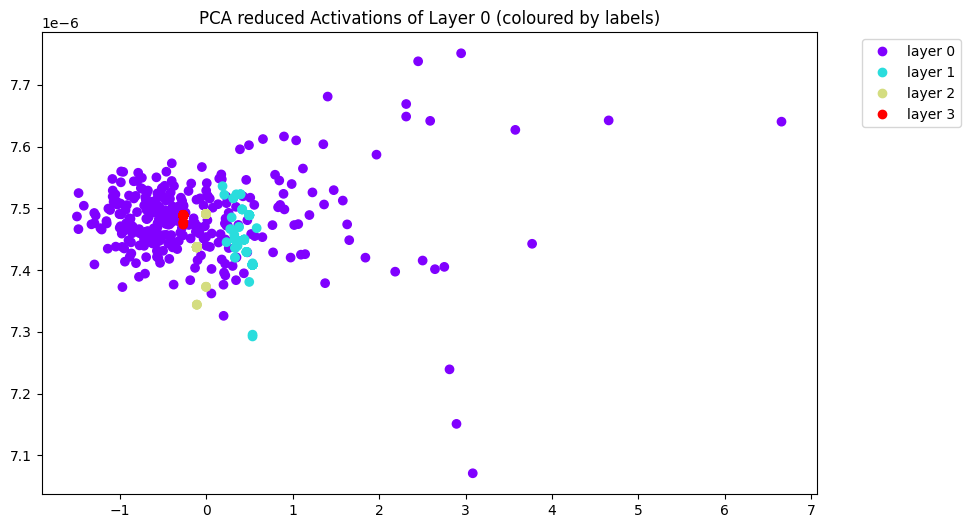

PCA DimRed explained variance ratio:
1st dimension: 0.9998237490653992
2nd dimension: 0.00017822175868786871


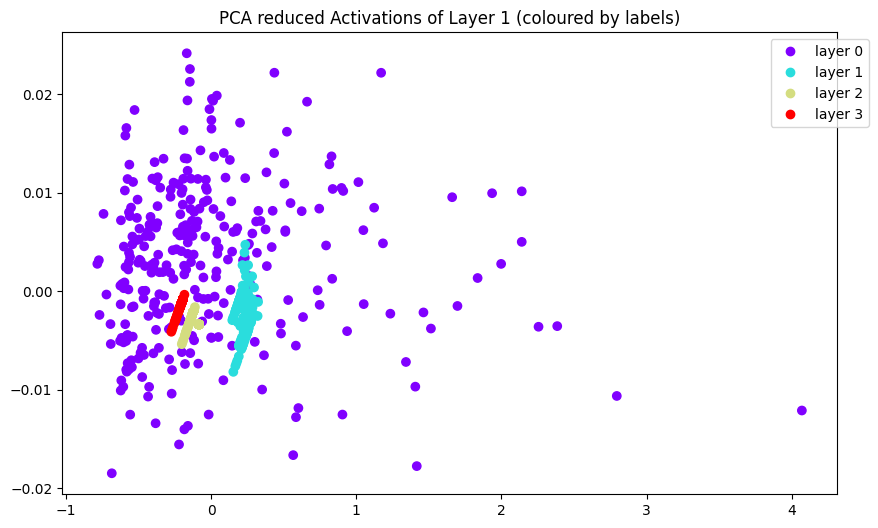

PCA DimRed explained variance ratio:
1st dimension: 0.9862550497055054
2nd dimension: 0.013700962997972965


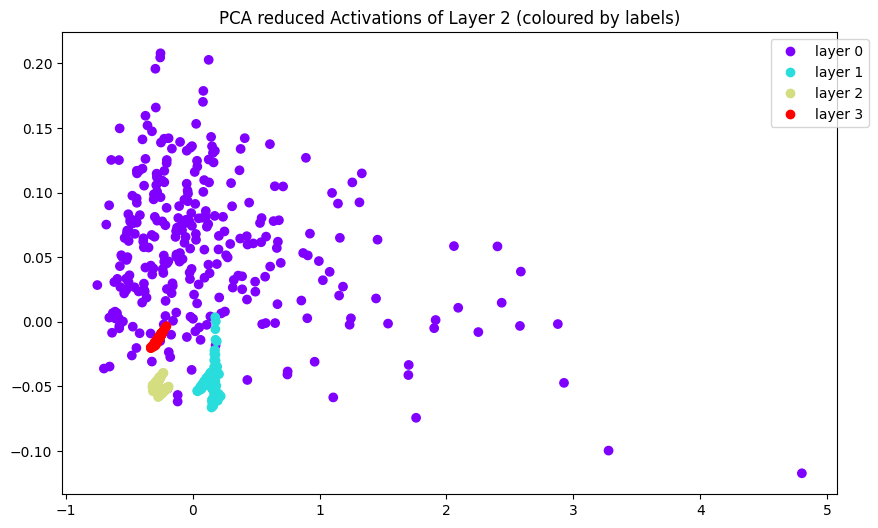

PCA DimRed explained variance ratio:
1st dimension: 0.6958605051040649
2nd dimension: 0.30408748984336853


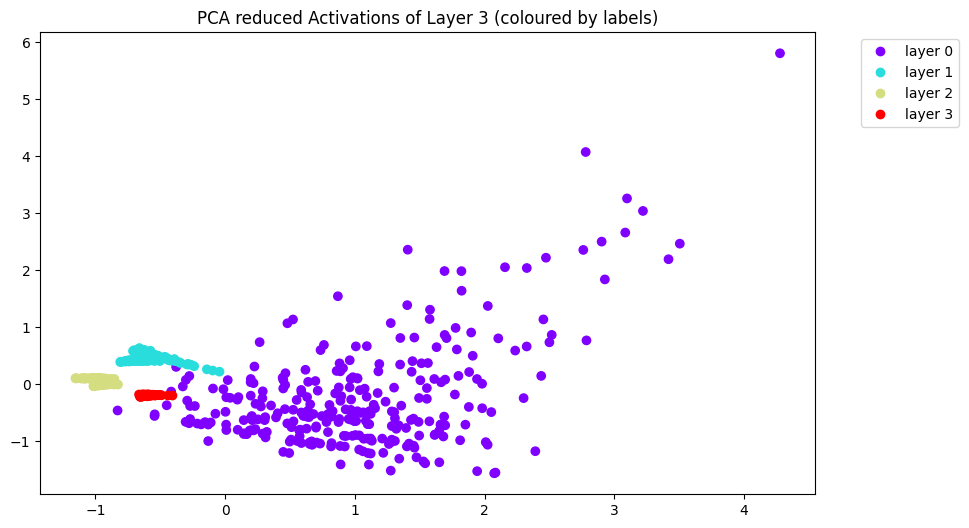

PCA DimRed explained variance ratio:
1st dimension: 0.888636589050293
2nd dimension: 0.11135214567184448


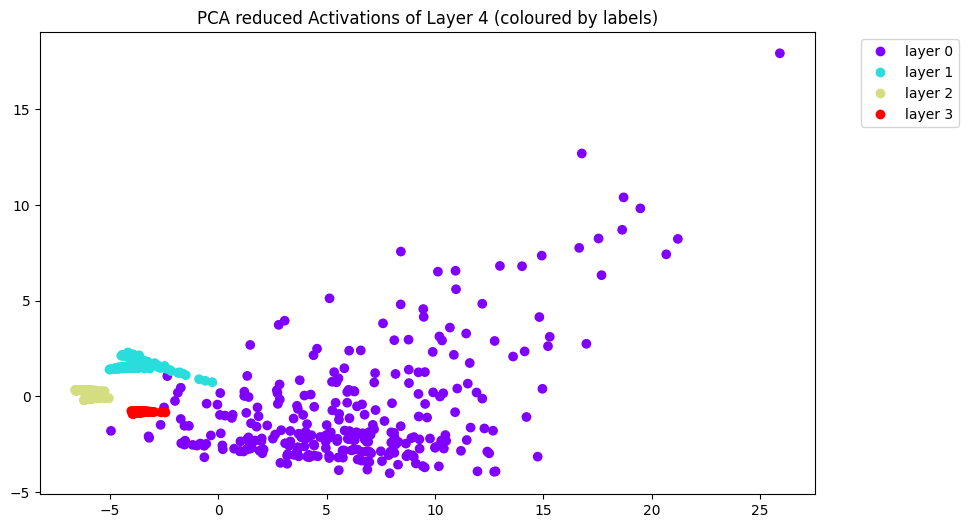

-----------------------------------------------------------------------
Start DimRed with t-SNE


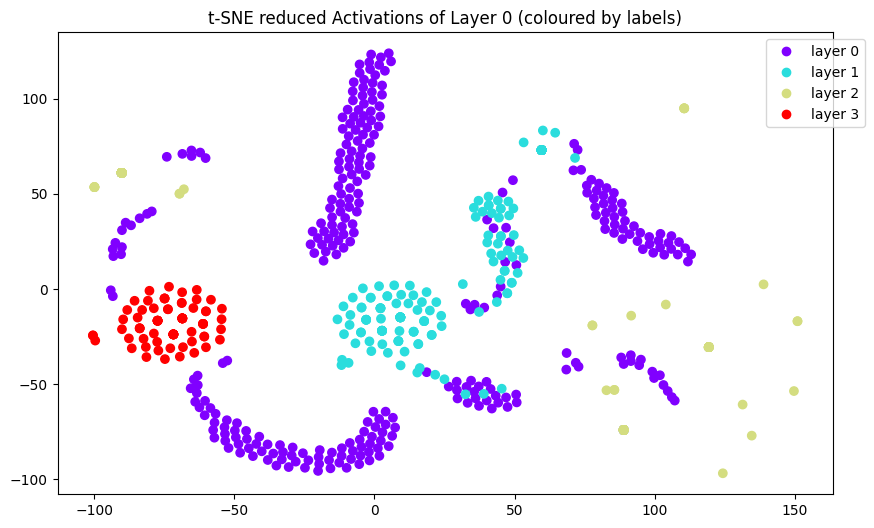

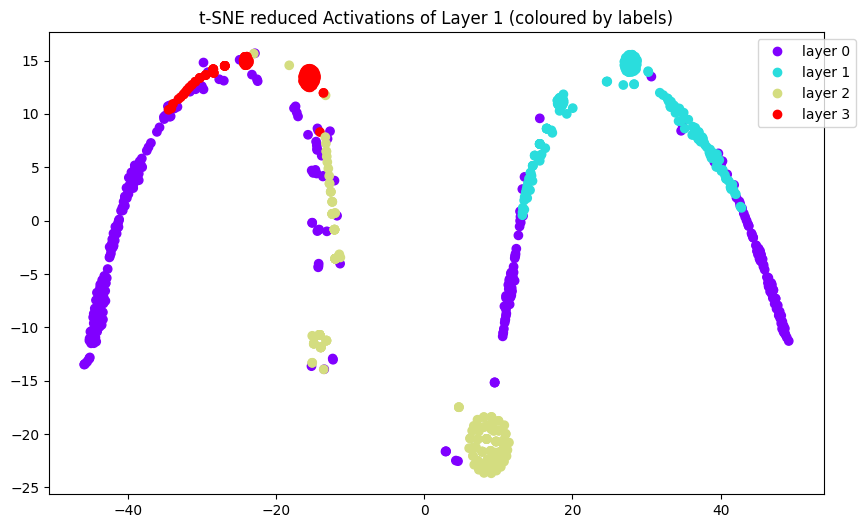

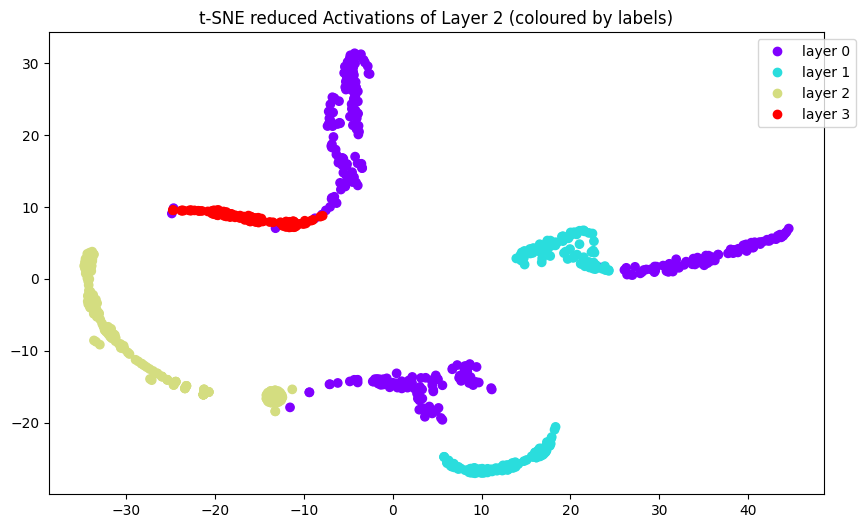

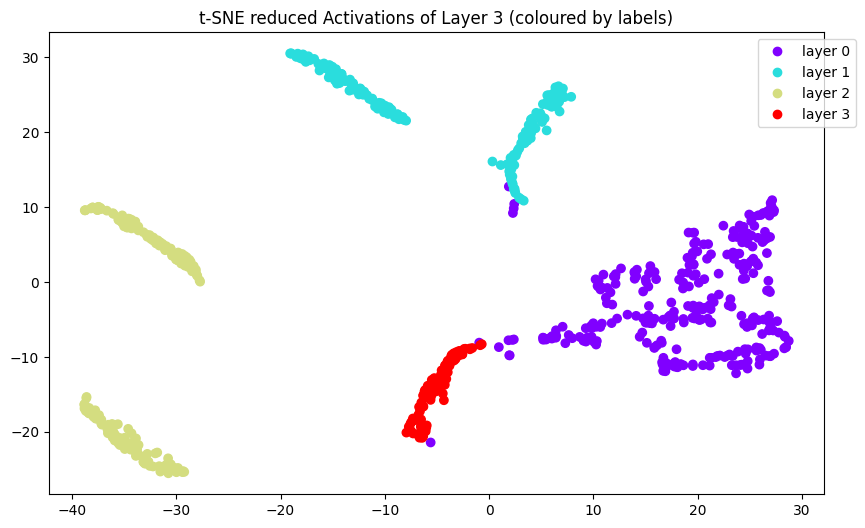

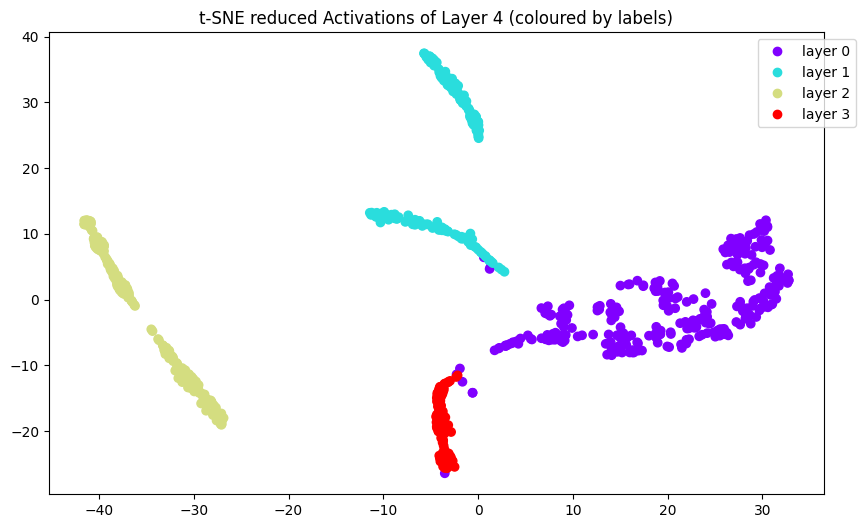

-----------------------------------------------------------------------
Start DimRed with UMAP


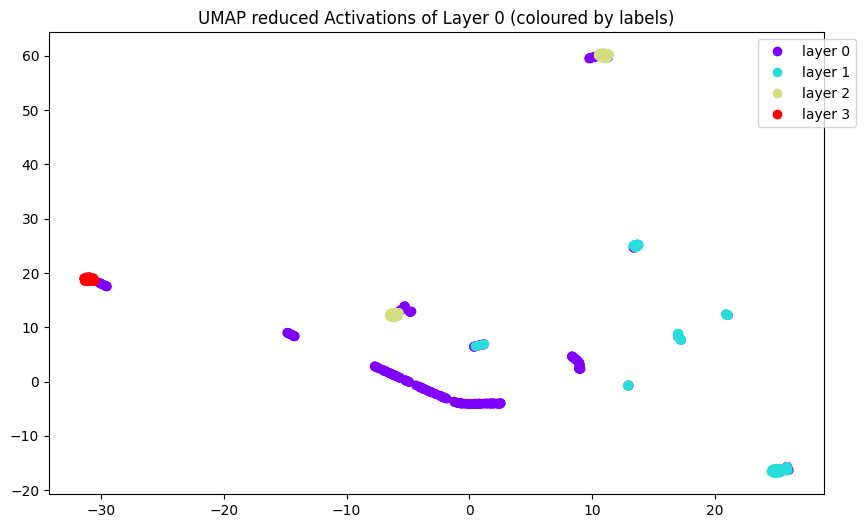

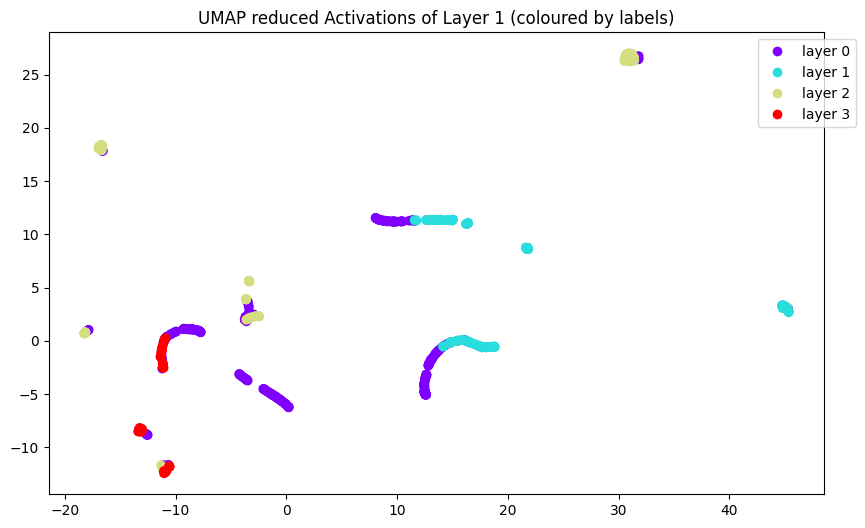

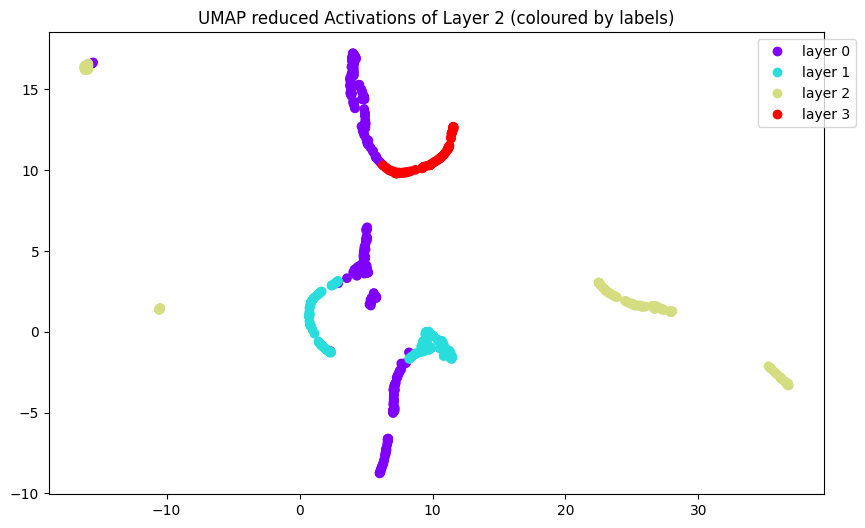

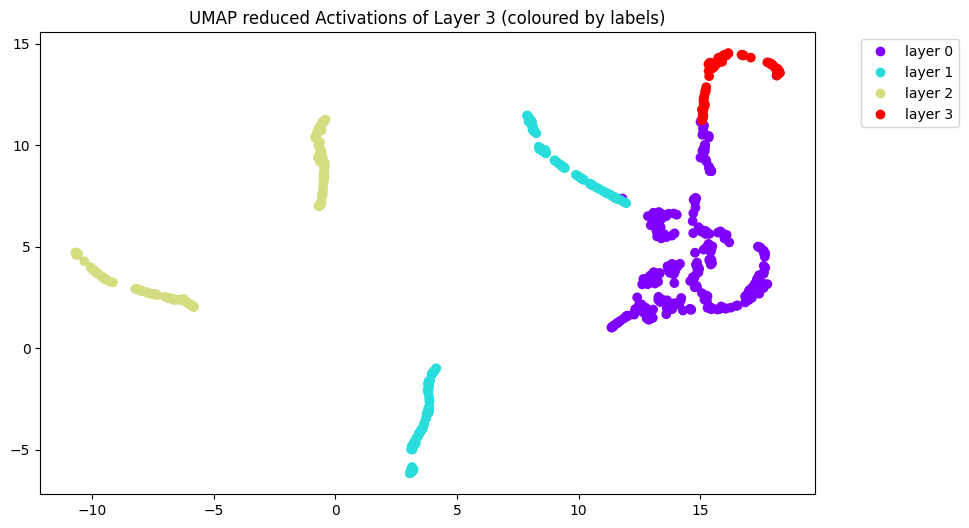

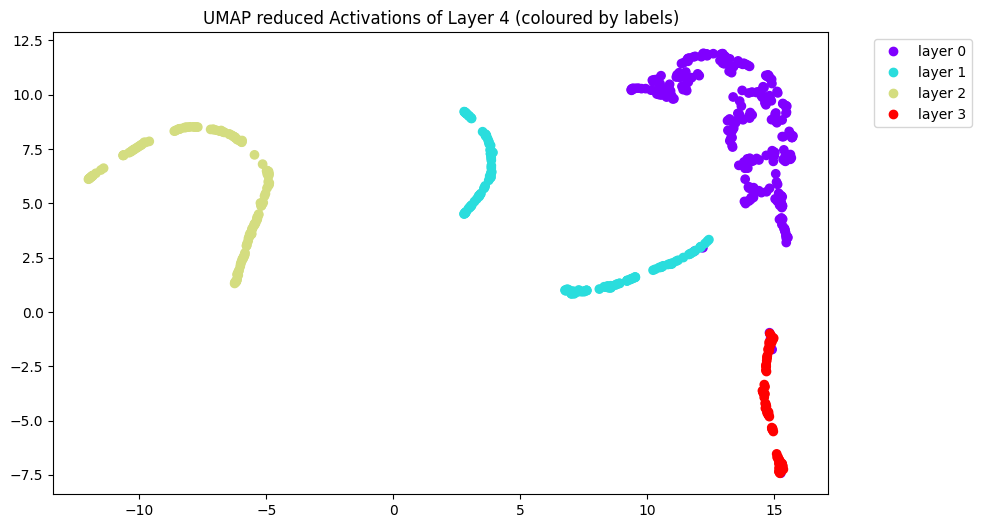

-----------------------------------------------------------------------


In [ ]:
################################################################################
# [3.] Observe the activations of the layers ===================================
#      and use dimensionality reduction ========================================
################################################################################
import os

import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap


gcn_model_activation_dict = activation_list

# [3.1.] Plot of the activation space ------------------------------------------
def plot_activation_space(data: np.ndarray,
                          labels: np.ndarray,
                          activation_type: str,
                          layer_num: int,
                          note:str =""):

    """
    :param data: Activation data after dimensionality reduction
    :param labels: Labels of nodes
    :param activation_type: String representation of the
                            dimensionality reduction function
    :param layer_num: Number of layer
    :param note: Additional note for the title of the figure
    """

    rows = len(data)

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_title(f"{activation_type} Activations of Layer {layer_num} {note}")

    scatter = ax.scatter(data[:,0], data[:,1], c=labels, cmap='rainbow')

    labels_unique = list(np.unique(labels))
    labels_str_unique = ["layer " + str(s) for s in labels_unique]

    ax.legend(handles=scatter.legend_elements()[0],
              labels=labels_str_unique,
              bbox_to_anchor=(1.05, 1))
    plt.show()
    plt.close()

# [3.2.] Dimensionality reduction of each layer's activation with PCA ----------
print("Start DimRed with PCA")

pca_models = []
pca_data = []

# Iterate for each layer's activation ------------------------------------------
for layer_num, key in enumerate(gcn_model_activation_dict):

    activation = torch.squeeze(gcn_model_activation_dict[key]).detach().numpy()

    # Apply the PCA dimensionality reduction -----------------------------------
    pca_model = PCA(n_components=2)
    activation_dim_red = pca_model.fit_transform(activation)

    # Calculate the explained variance ratio of the data in each of the --------
    # two dimensions -----------------------------------------------------------
    print("PCA DimRed explained variance ratio:")
    print(f"1st dimension: {pca_model.explained_variance_ratio_[0]}")
    print(f"2nd dimension: {pca_model.explained_variance_ratio_[1]}")

    # Plot the activation space in reduced dimensions --------------------------
    plot_activation_space(activation_dim_red,
                          graph_ba_shapes_labels,
                          "PCA reduced",
                          layer_num,
                          "(coloured by labels)")

    pca_models.append(pca_model)
    pca_data.append(activation_dim_red)

print("-----------------------------------------------------------------------")

# [3.3.] Dimensionality reduction with t-SNE -----------------------------------
print("Start DimRed with t-SNE")

tsne_models = []
tsne_data = []

for layer_num, key in enumerate(gcn_model_activation_dict):

    activation = torch.squeeze(gcn_model_activation_dict[key]).detach().numpy()

    # Apply the TSNE dimensionality reduction ----------------------------------
    tsne_model = TSNE(n_components=2)

    activation_dim_red = tsne_model.fit_transform(activation)
    plot_activation_space(activation_dim_red,
                          graph_ba_shapes_labels,
                          "t-SNE reduced", layer_num, "(coloured by labels)")

    tsne_models.append(tsne_model)
    tsne_data.append(activation_dim_red)

print("-----------------------------------------------------------------------")

# [3.4.] Dimensionality reduction with UMAP ------------------------------------
print("Start DimRed with UMAP")

umap_models = []
umap_data = []

for layer_num, key in enumerate(gcn_model_activation_dict):

    activation = torch.squeeze(gcn_model_activation_dict[key]).detach().numpy()

    # Apply the UMAP dimensionality reduction ----------------------------------
    umap_model = umap.UMAP(n_components=2)

    # Plot the activation space in reduced dimensions --------------------------
    activation_dim_red = umap_model.fit_transform(activation)
    plot_activation_space(activation_dim_red,
                          graph_ba_shapes_labels,
                          "UMAP reduced", layer_num,
                          "(coloured by labels)")

    # Plot the activation space in reduced dimensions --------------------------
    umap_models.append(umap_model)
    umap_data.append(activation_dim_red)

print("-----------------------------------------------------------------------")




In [ ]:
################################################################################
# [4.] Clustering ==============================================================
################################################################################
import networkx as nx
from sklearn.cluster import KMeans, MeanShift, DBSCAN, AgglomerativeClustering
from sklearn.neighbors import NearestCentroid
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score
from torch_geometric.utils.convert import to_networkx


def get_node_distances(clustering_model: np.ndarray,
                       activation_data: np.ndarray) -> np.ndarray:
    """
    Sort all nodes belonging in the cluster representing the concept
    by their distance to the center of the cluster.

    :param clustering_model: Type of the clustering model
    :param activation_data: Activation of layer
    """

    if isinstance(clustering_model, AgglomerativeClustering) or \
       isinstance(clustering_model, DBSCAN):

        x, y_predict = activation_data

        # Compute the nearest centroid to the data of the ----------------------
        # activation of the layer ----------------------------------------------
        clf = NearestCentroid()
        clf.fit(x, y_predict)

        centroids = clf.centroids_

        # Sort all nodes according to the distance to the centroid -------------
        res = pairwise_distances(centroids, x)
        res_sorted = np.argsort(res, axis=-1)

    elif isinstance(clustering_model, KMeans):

        # If the method is K-Means ---------------------------------------------
        # apply it to the output of the activation of the layer ----------------
        res_sorted = clustering_model.transform(activation_data)

    return res_sorted


def get_top_subgraphs(top_indices: np.ndarray,
                      y: torch.Tensor,
                      edges: np.ndarray,
                      n_hop_neighborhood_size: int,
                      graph_data=None, graph_name=None) -> tuple:

    """
    Create (sub-)graphs from the neighborhood of each node that was
    selected as being nearest to the centroid of the cluster/concept
    for plotting purposes. Define the colours of the node and its neighboring
    ones.

    :param top_indices: Indices of nodes to plot
    :param y: Labels of nodes
    :param edges: Edges on node
    :param n_hop_neighborhood_size: Neighborhood size (n-hop) -
        the method actually uses externally defined "num_expansions"
    :param graph_data: Unused in this example (None)
    :param graph_name: Unused in this example (None)
    """

    graphs = []
    color_maps = []
    labels = []
    node_labels = []

    df = pd.DataFrame(edges)

    # Iterate over all nodes belonging to the top_indices ----------------------
    # meaning the nodes that are nearest to the cluster/concept centroid -------
    for idx in top_indices:


        neighbours = list()
        neighbours.append(idx)

        # Get all nodes in the num_expansions-hop neighborhood -----------------
        for i in range(0, num_expansions):
            new_neighbours = list()
            for e in edges:
                if (e[0] in neighbours) or (e[1] in neighbours):
                    new_neighbours.append(e[0])
                    new_neighbours.append(e[1])

            neighbours = neighbours + new_neighbours
            neighbours = list(set(neighbours))

        # Create the graph from the node and its neighboring nodes -------------
        new_G = nx.Graph()
        df_neighbours = df[(df[0].isin(neighbours)) & (df[1].isin(neighbours))]
        remaining_edges = df_neighbours.to_numpy()
        new_G.add_edges_from(remaining_edges)

        # Define the colors of the node in the plot and of its -----------------
        # neighboring nodes ----------------------------------------------------
        color_map = []
        node_label = {}
        if graph_data is None:

            for node in new_G:
                if node in top_indices:
                    color_map.append('green')
                else:
                    color_map.append('pink')
        else:

            for node in zip(new_G):
                node = node[0]
                color_idx = graph_data[node]
                color_map.append(color_idx)
                node_label[node] = f"{ids[color_idx]}"

        color_maps.append(color_map)
        graphs.append(new_G)
        labels.append(y[idx])
        node_labels.append(node_label)

    return graphs, color_maps, labels, node_labels


def plot_clusters(data: np.ndarray, labels: np.ndarray,
                  clustering_type: str, k: int, layer_num: int,
                  data_type: str, reduction_type: str ="", note: str =""):
    """
    Plotting function of the content of the clusters.
    Each node of the graph is a point in this plot.
    The colors correspond to the colors of the clusters.

    :param data: Data passed from dimensionality reduction
    :param labels: Labels of each node
    :param clustering_type: Name of clustering method (f.e. k-means)
    :param k: Number of concepts/clusters
    :param layer_num: Number of layer
    :param data_type: Type of data (f.e. "raw")
    :param reduction_type: Name of dimensionality reduction method
    :param note: Extra string that can be used in the title
    """

    fig, ax = plt.subplots(figsize=(12, 8))
    fig.suptitle(f'{clustering_type} Clustered {data_type} ' \
                 f'Activations of Layer {layer_num} {note}')

    for i in range(k):
        scatter = ax.scatter(data[labels == i,0],
                             data[labels == i,1],
                             label=f'Cluster {i}')

    ncol = 1
    if k > 20:
        ncol = int(k / 20) + 1

    ax.legend(bbox_to_anchor=(1.05, 1), ncol=ncol)

    plt.show()
    plt.close()

def plot_samples(clustering_model, activation_data: np.ndarray, y: torch.Tensor,
                 layer_num: int, k: int, clustering_type: str,
                 reduction_type: str, num_nodes_view: int,
                 edges: np.ndarray, num_expansions: int,
                 graph_data: str = None, graph_name: str = None):
    """
    Plot the nodes that are nearer to the cluster that represents
    the concept they belong to, together with their n-hop neighbourhood.

    :param clustering_model: Clustering method (f.e. K-means)
    :param data: Data of activation for a particular layer
    :param y: Label of nodes
    :param layer_num: Number of layer
    :param k: Number of clusters/concepts
    :param clustering_type: Name of clustering method (f.e. k-means)
    :param reduction_type: Name of dimensionality reduction method
    :param num_nodes_view: Number of nodes nearest to the centroid of the
                           cluster/centroid to plot
    :param edges: Edges of the node
    :param num_expansions: Number of nodes in the neighborhood of the
                           plotting node
    :param graph_data: Unused in this example (None)
    :param graph_name: Unused in this example (None)
    """

    # Compute the nodes that are nearest to the centroid of the clusters -------
    res_sorted = get_node_distances(clustering_model, activation_data)

    if isinstance(num_nodes_view, int):
        num_nodes_view = [num_nodes_view]
    col = sum([abs(number) for number in num_nodes_view])

    # Plot the graphs of each concept in the same row along with their ---------
    # n-hop neighborhood -------------------------------------------------------
    fig, axes = plt.subplots(k, col, figsize=(18, 3 * k + 2))
    fig.suptitle(f'Nearest Instances to {clustering_type} ' +
                 f'Cluster Centroid for {reduction_type} ' +
                 f'Activations of Layer {layer_num}',
                 y=1.005)

    if graph_data is not None:
        fig2, axes2 = plt.subplots(k, col, figsize=(18, 3 * k + 2))
        fig2.suptitle(f'Nearest Instances to {clustering_type} ' \
                      f'Cluster Centroid for {reduction_type} ' \
                      f'Activations of Layer {layer_num} (by node index)',
                      y=1.005)

    l = list(range(0, k))
    sample_graphs = []
    sample_feat = []

    for i, ax_list in zip(l, axes):

        if isinstance(clustering_model, AgglomerativeClustering) or \
           isinstance(clustering_model, DBSCAN):
            distances = res_sorted[i]
        elif isinstance(clustering_model, KMeans):
            distances = res_sorted[:, i]

        top_graphs, color_maps = [], []

        for view in num_nodes_view:
            if view < 0:
                top_indices = np.argsort(distances)[::][view:]
            else:
                top_indices = np.argsort(distances)[::][:view]

            # Visualize the top representations --------------------------------
            # i.e. the ones closest to the cluster center of a concept --------o-
            tg, cm, labels, node_labels = get_top_subgraphs(top_indices,
                                                            y,
                                                            edges,
                                                            num_expansions,
                                                            graph_data,
                                                            graph_name)
            top_graphs = top_graphs + tg
            color_maps = color_maps + cm

        if graph_data is None:

            for ax, new_G, color_map, g_label in zip(ax_list,
                                                     top_graphs,
                                                     color_maps,
                                                     labels):

                nx.draw(new_G, node_color=color_map, with_labels=True, ax=ax)
                ax.set_title(f"label {g_label}", fontsize=14)
        else:

            for ax, new_G, color_map, g_label, n_labels in zip(ax_list,
                                                               top_graphs,
                                                               color_maps,
                                                               labels,
                                                               node_labels):

                nx.draw(new_G, node_color=color_map, with_labels=True, ax=ax,
                        labels=n_labels)
                ax.set_title(f"label {g_label}", fontsize=14)

            for ax, new_G, color_map, g_label, n_labels in zip(axes2[i],
                                                               top_graphs,
                                                               color_maps,
                                                               labels,
                                                               node_labels):
                nx.draw(new_G, node_color=color_map, with_labels=True, ax=ax)
                ax.set_title(f"label {g_label}", fontsize=14)

        sample_graphs.append((top_graphs[0], top_indices[0]))
        sample_feat.append(color_maps[0])

    views = ''.join((str(i) + "_") for i in num_nodes_view)
    plt.show()
    plt.close()

    return sample_graphs, sample_feat


# [4.1.] Define the number of the nodes on each cluster/concept that will be ---
#        shown with the variable "num_nodes_view", -----------------------------
#        whereas the "num_expansions" define the n-hop neighborhood (n) --------
num_nodes_view = 5

# [4.2.] Transform the graph type from PyTorch Geometric (PyG) -----------------
#        to the networkx format ------------------------------------------------
graph_ba_shapes_nx = to_networkx(graph_ba_shapes)
edge_list = torch.from_numpy(np.array(graph_ba_shapes_nx.edges))
edges = edge_list.numpy()

raw_kmeans_sample_feat = []
raw_kmeans_sample_graphs = []
raw_kmeans_models = []

# Iterate over all activations of all layers -----------------------------------
for layer_num, key in enumerate(gcn_model_activation_dict):

    activation = torch.squeeze(gcn_model_activation_dict[key]).detach().numpy()

    # [4.3.] Apply K-means clustering and measure ------------------------------
    #        the mean Silhouette Coefficient of all activation samples ---------
    kmeans_model = KMeans(n_clusters=k, random_state=0)
    kmeans_model = kmeans_model.fit(activation)
    pred_labels = kmeans_model.predict(activation)

    silhouette_score_kmeans = silhouette_score(activation, pred_labels)
    print(f"Mean Silhouette Coefficient with k-means: {silhouette_score_kmeans}")

    # [4.4.] Plot the clusters on the 2D after dimensionality reduction --------
    plot_clusters(pca_data[layer_num], pred_labels, "k-Means", k,
                  layer_num, "Raw", "_PCA",
                  "(PCA reduced)")
    plot_clusters(tsne_data[layer_num], pred_labels, "k-Means", k,
                  layer_num, "Raw", "_TSNE",
                  "(t-SNE reduced)")
    plot_clusters(umap_data[layer_num], pred_labels, "k-Means", k,
                  layer_num, "Raw", "_UMAP",
                  "(UMAP reduced)")

    # [4.5.] Plot the graphs that belong to each of the discovered concepts ----
    sample_graphs, sample_feat = plot_samples(
        kmeans_model,
        activation,
        graph_ba_shapes["y"],
        layer_num, k, "Kmeans", "raw",
        num_nodes_view,
        edges,
        num_expansions)

    raw_kmeans_sample_graphs.append(sample_graphs)
    raw_kmeans_sample_feat.append(sample_feat)
    raw_kmeans_models.append(kmeans_model)


Output hidden; open in https://colab.research.google.com to view.

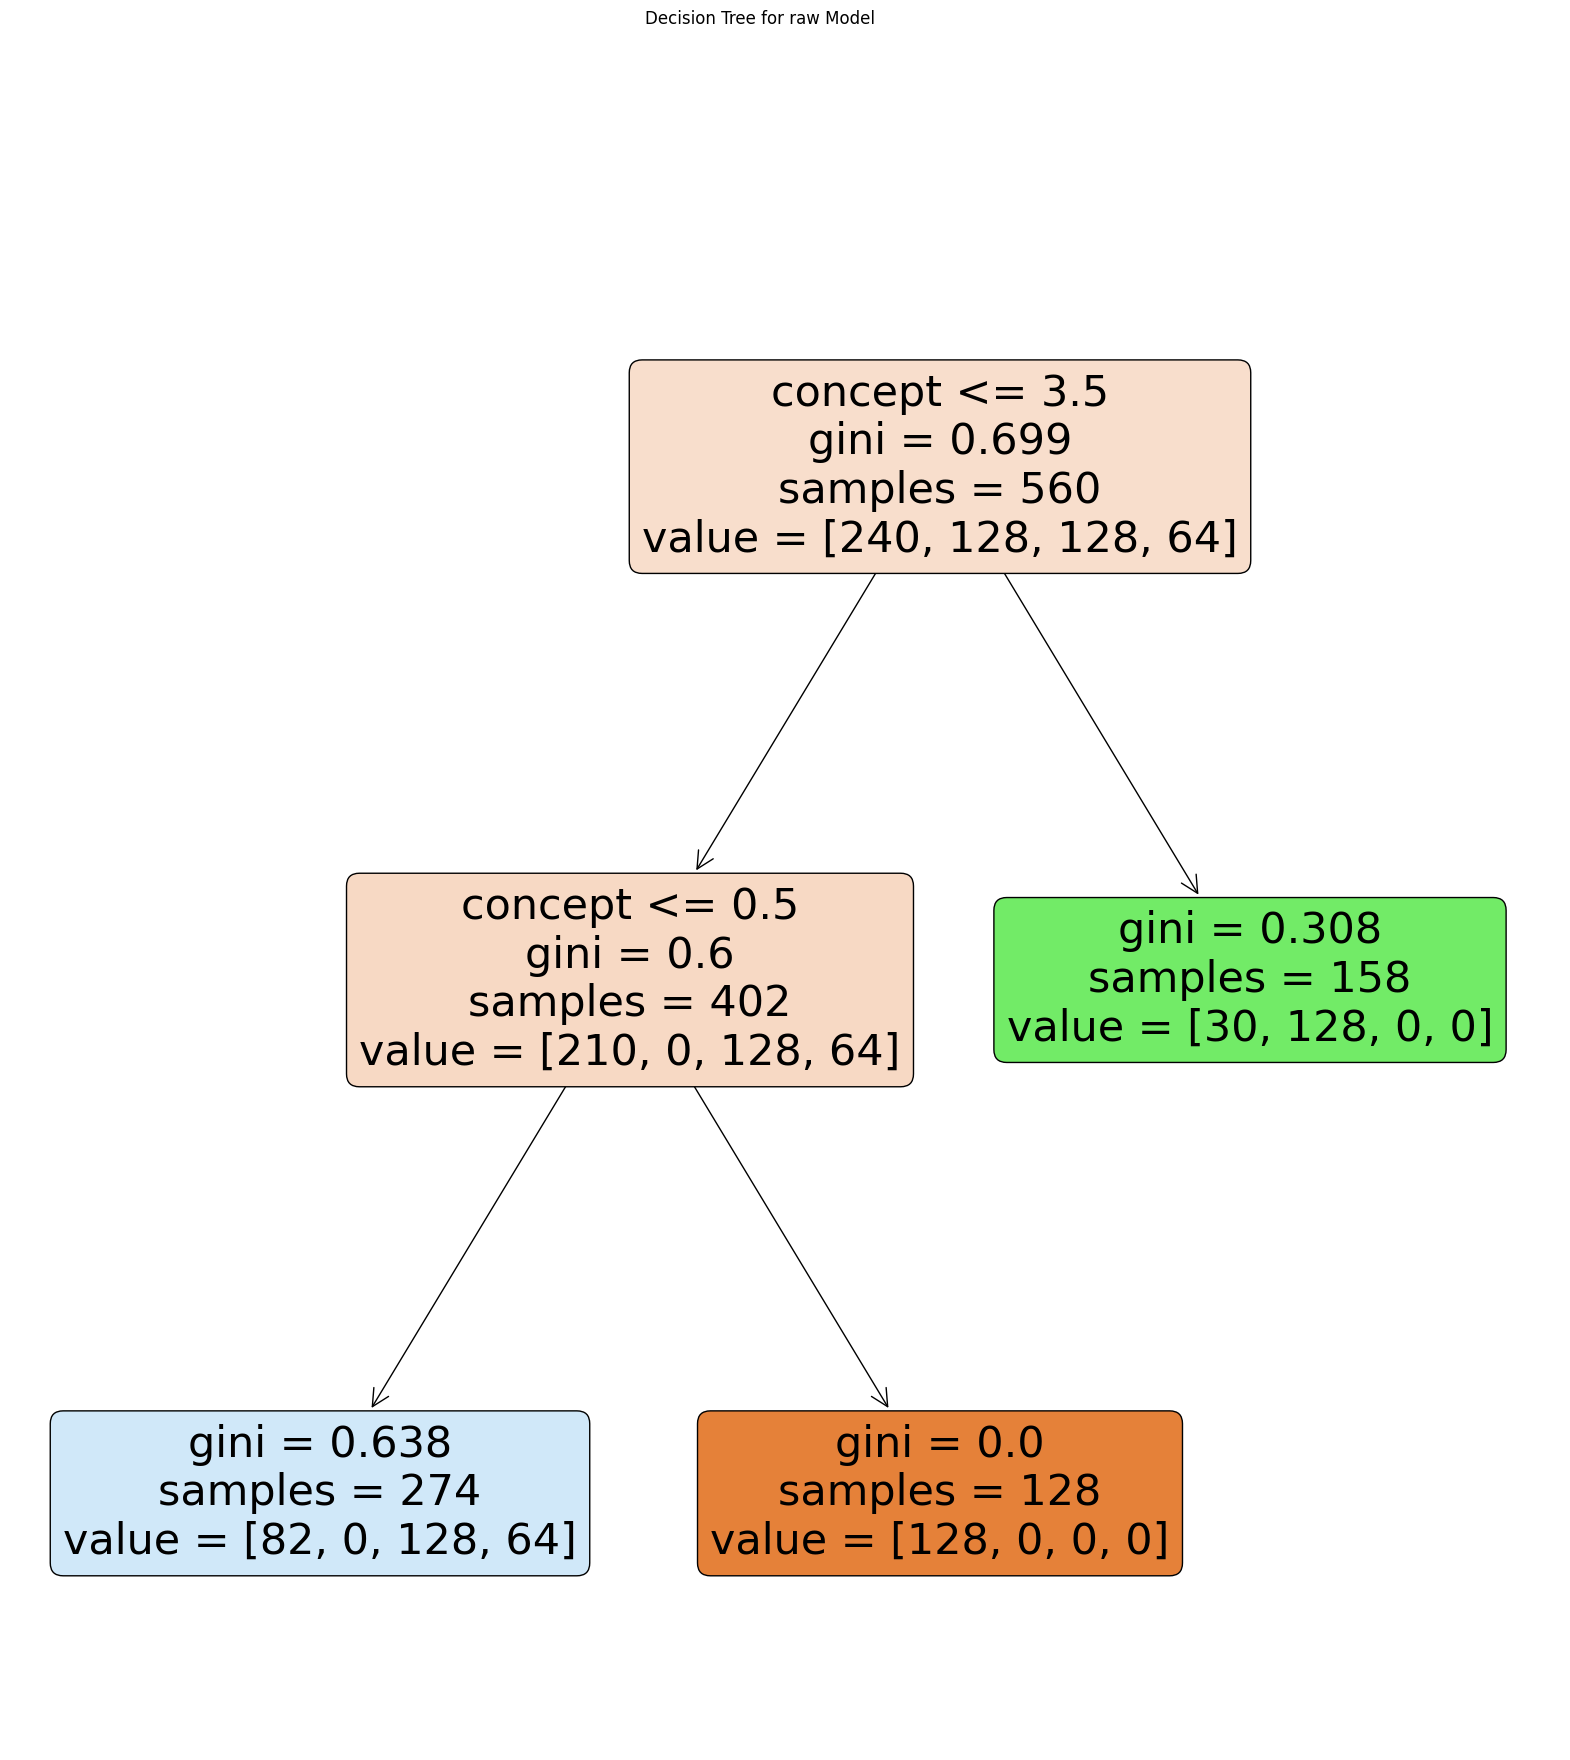

0   0.6642857142857143


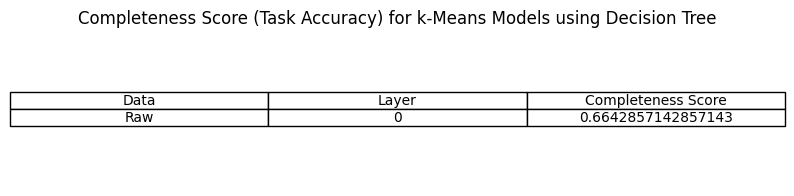

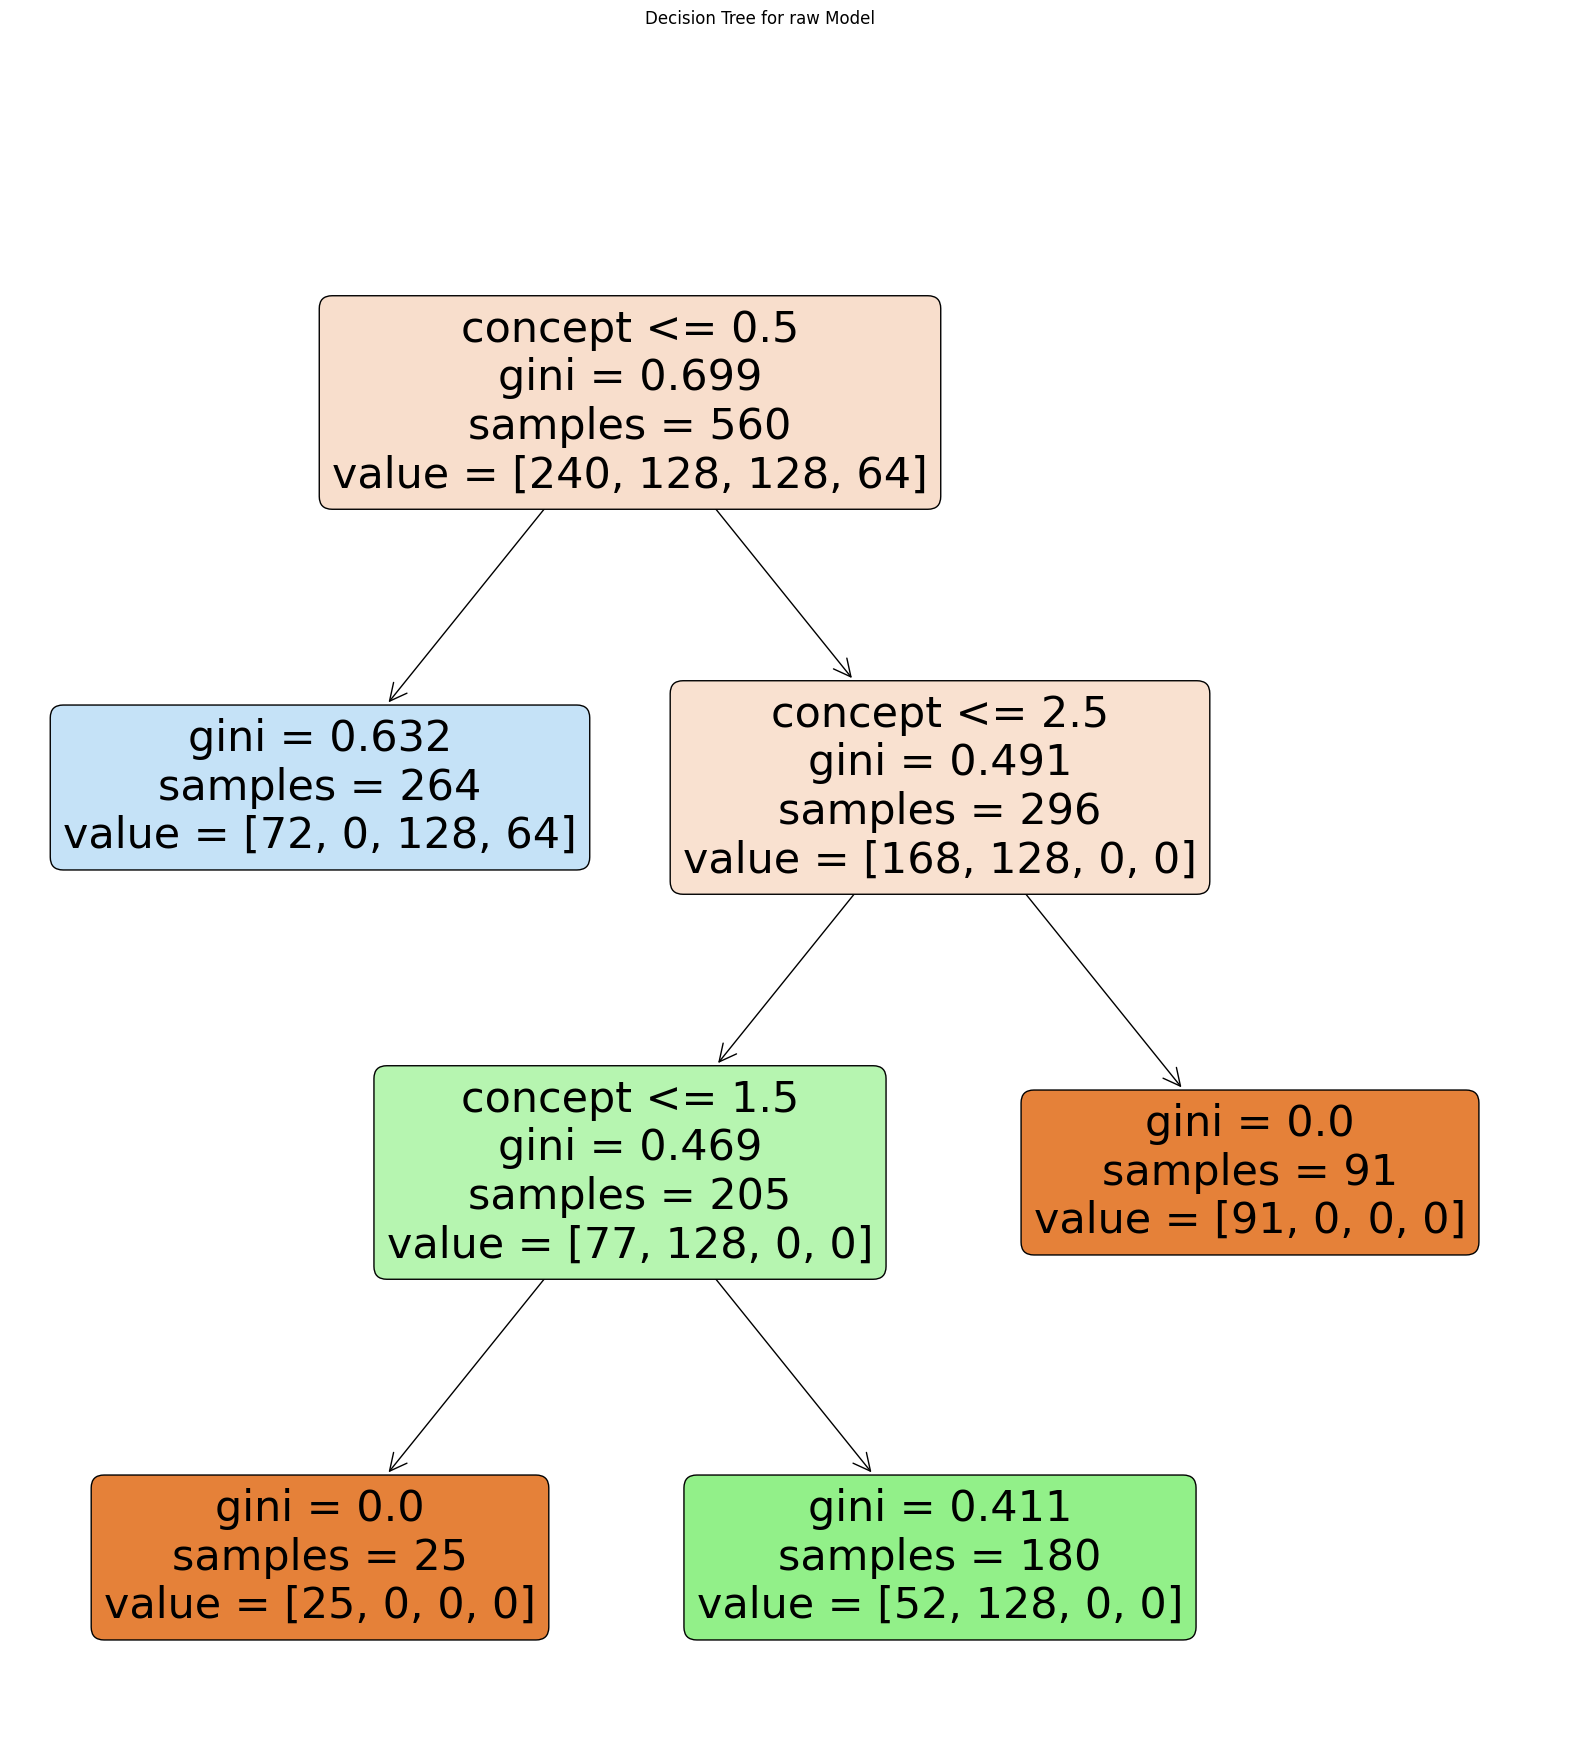

1   0.6142857142857143


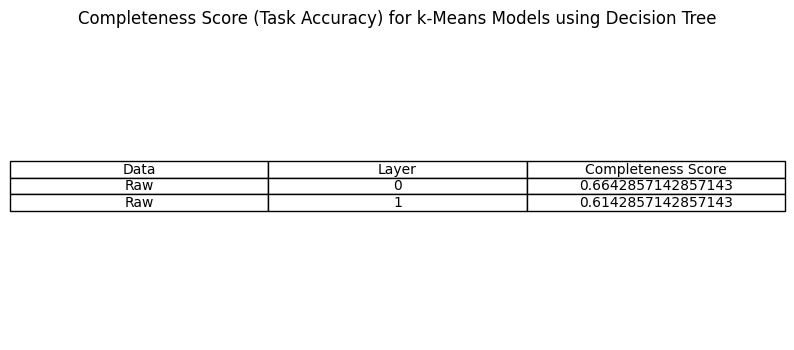

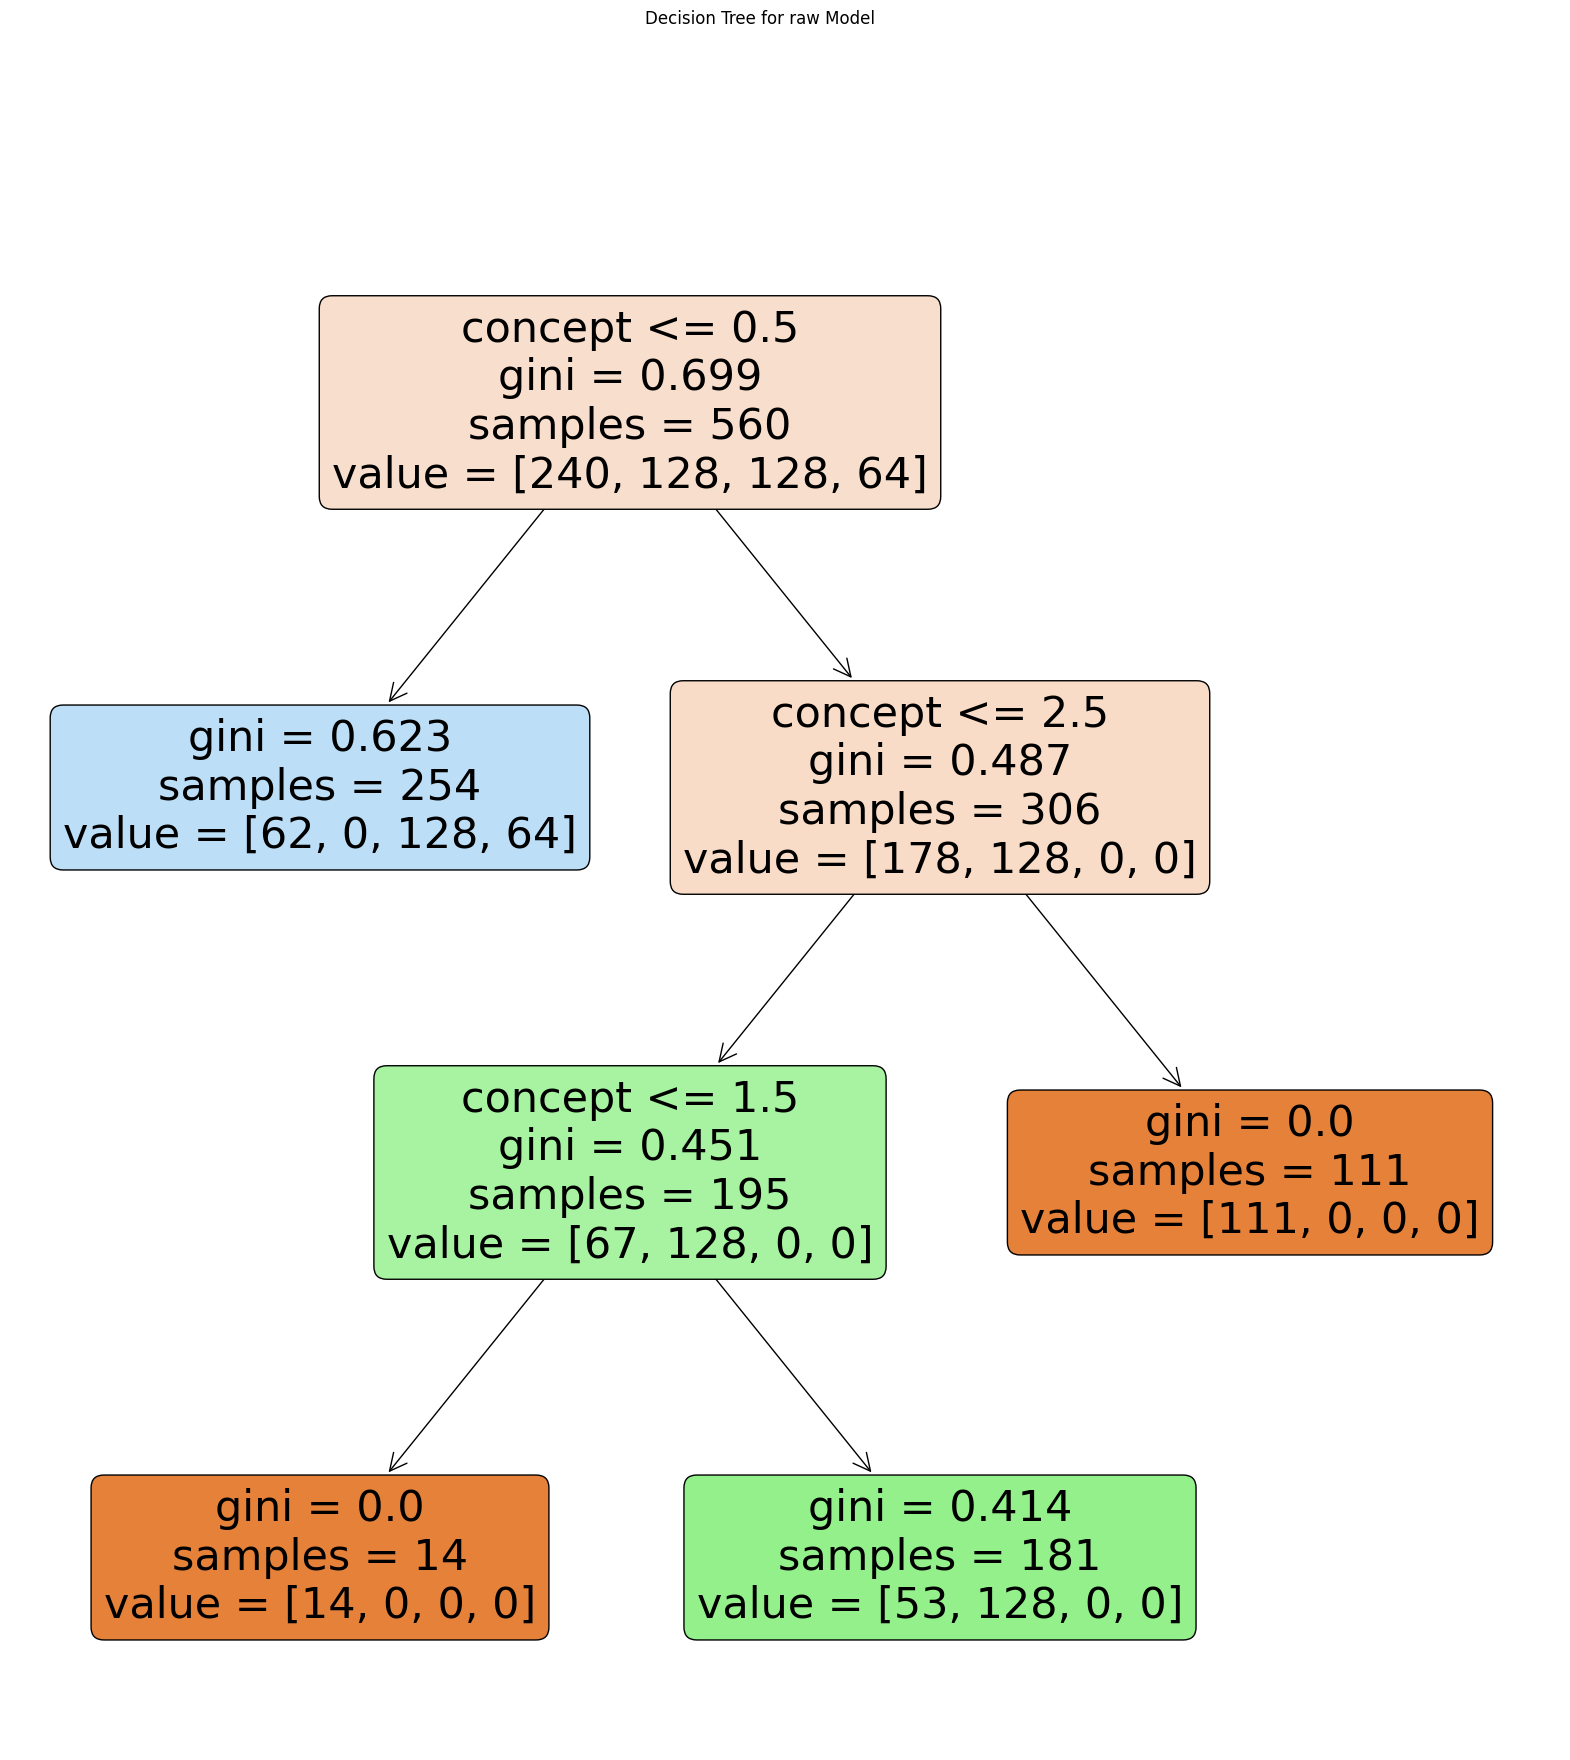

2   0.6428571428571429


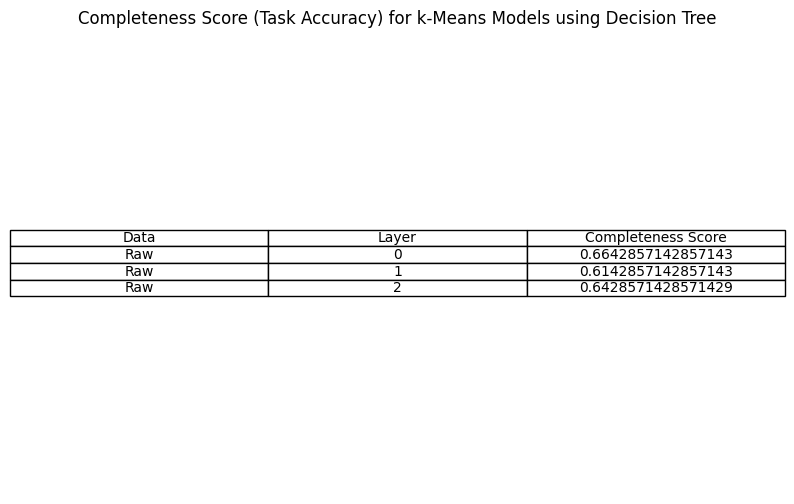

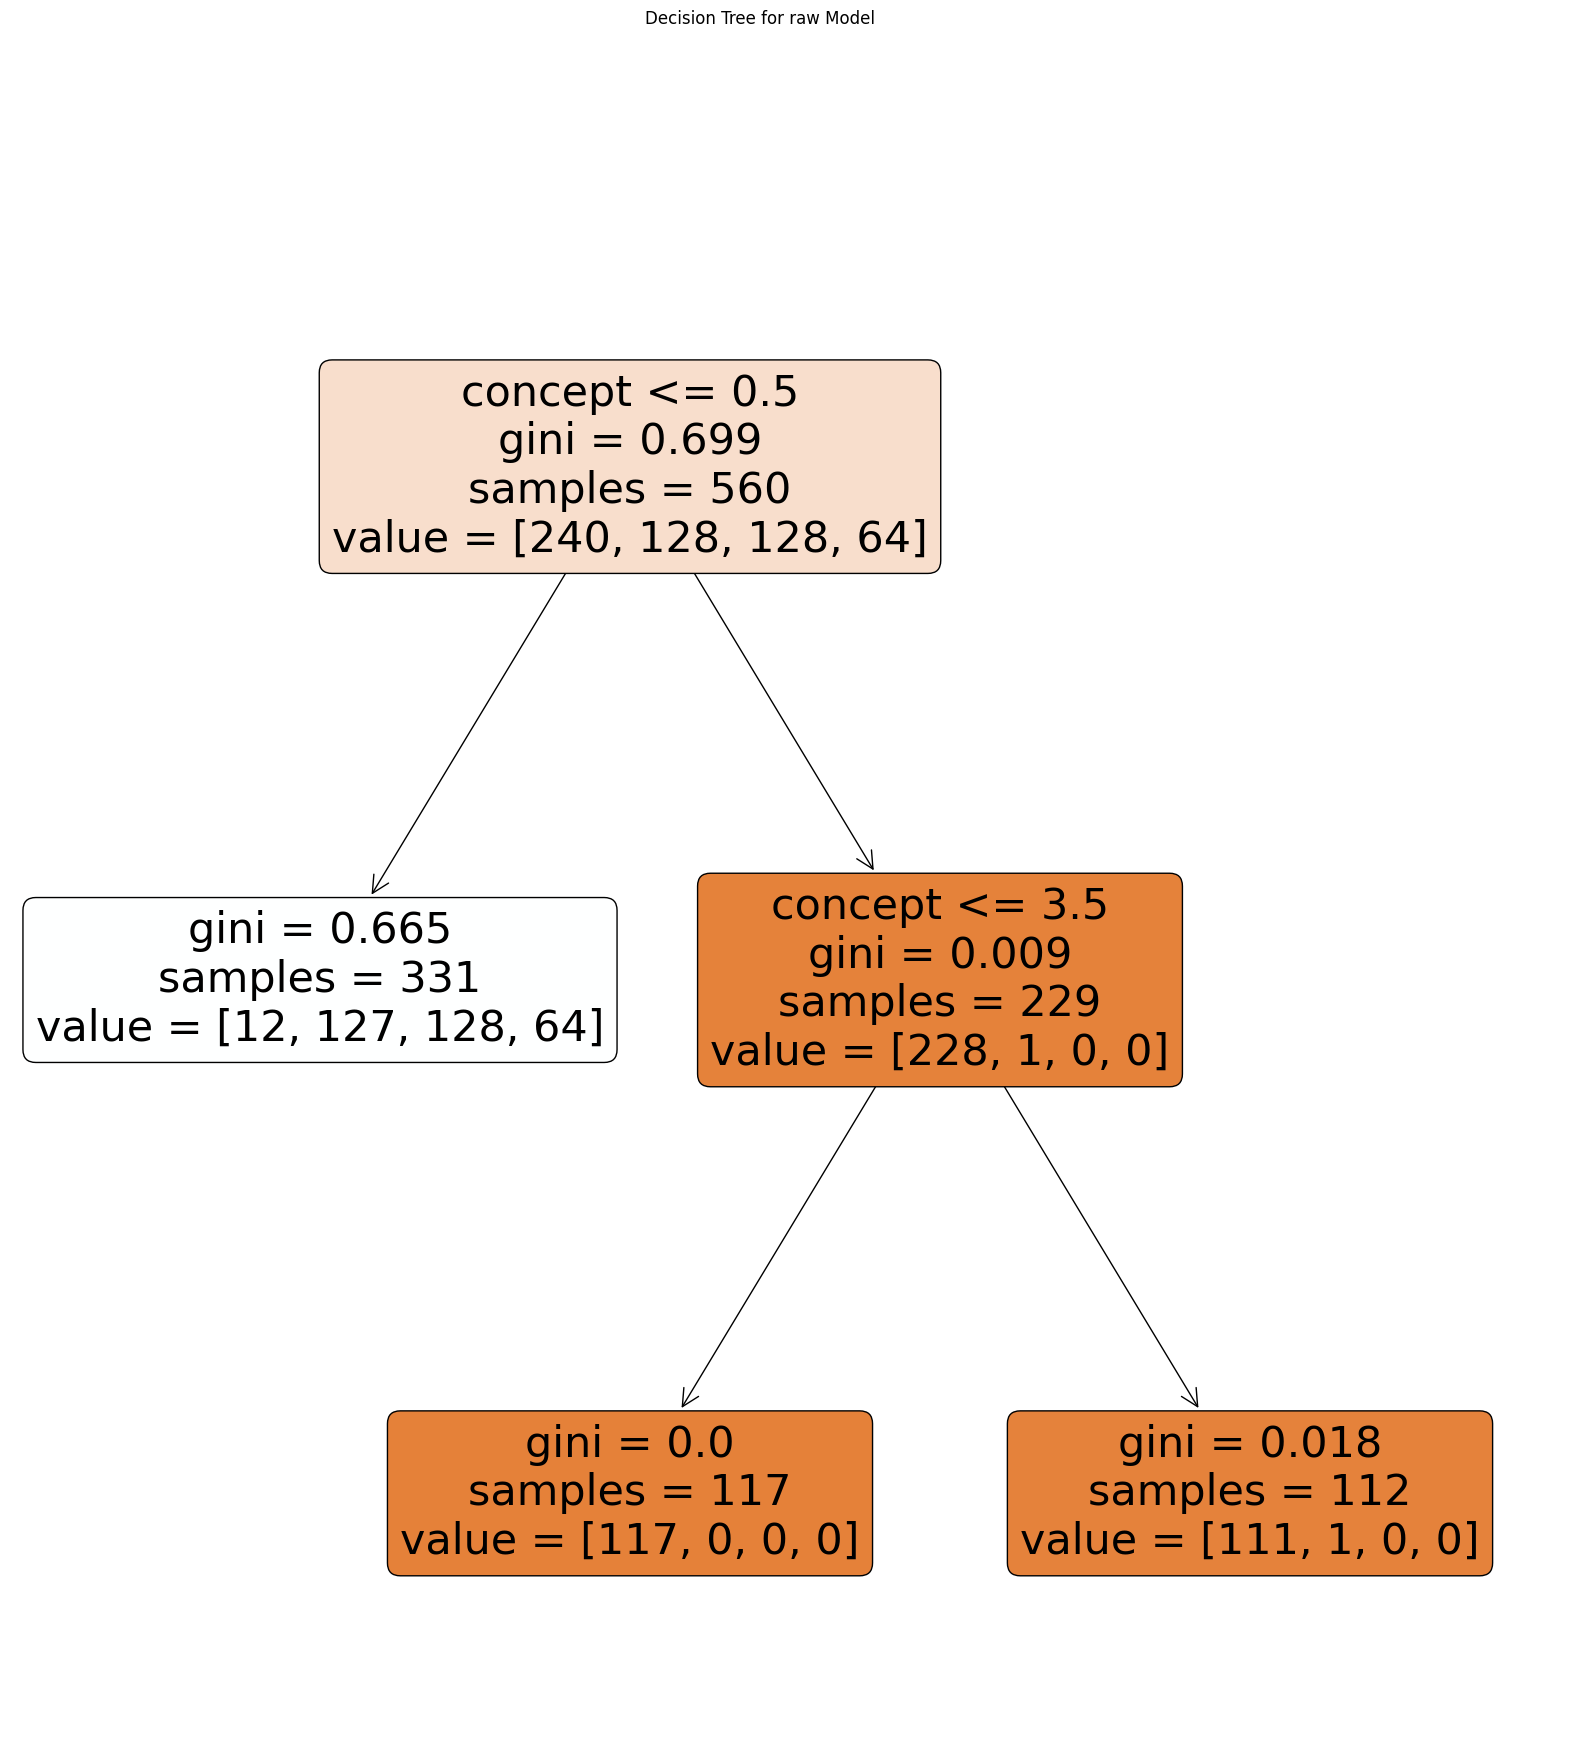

3   0.6214285714285714


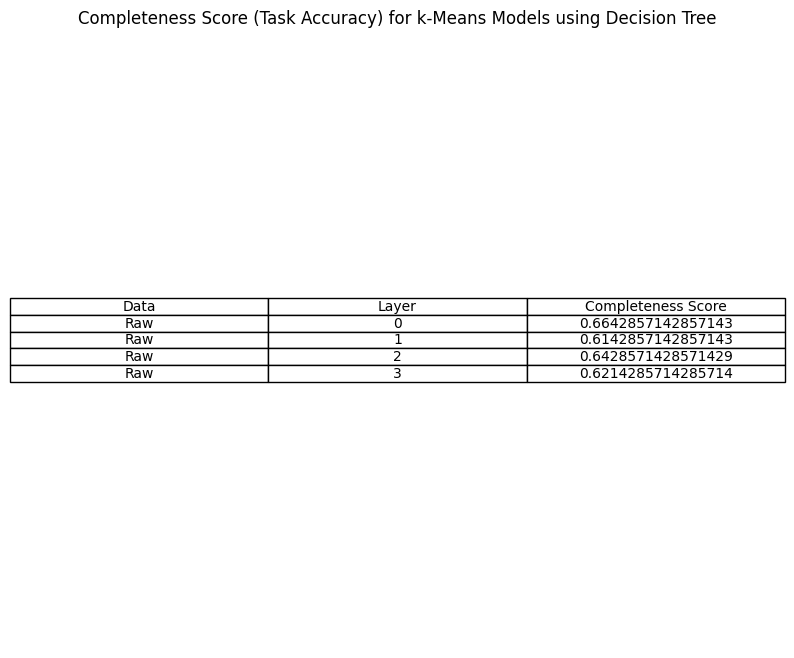

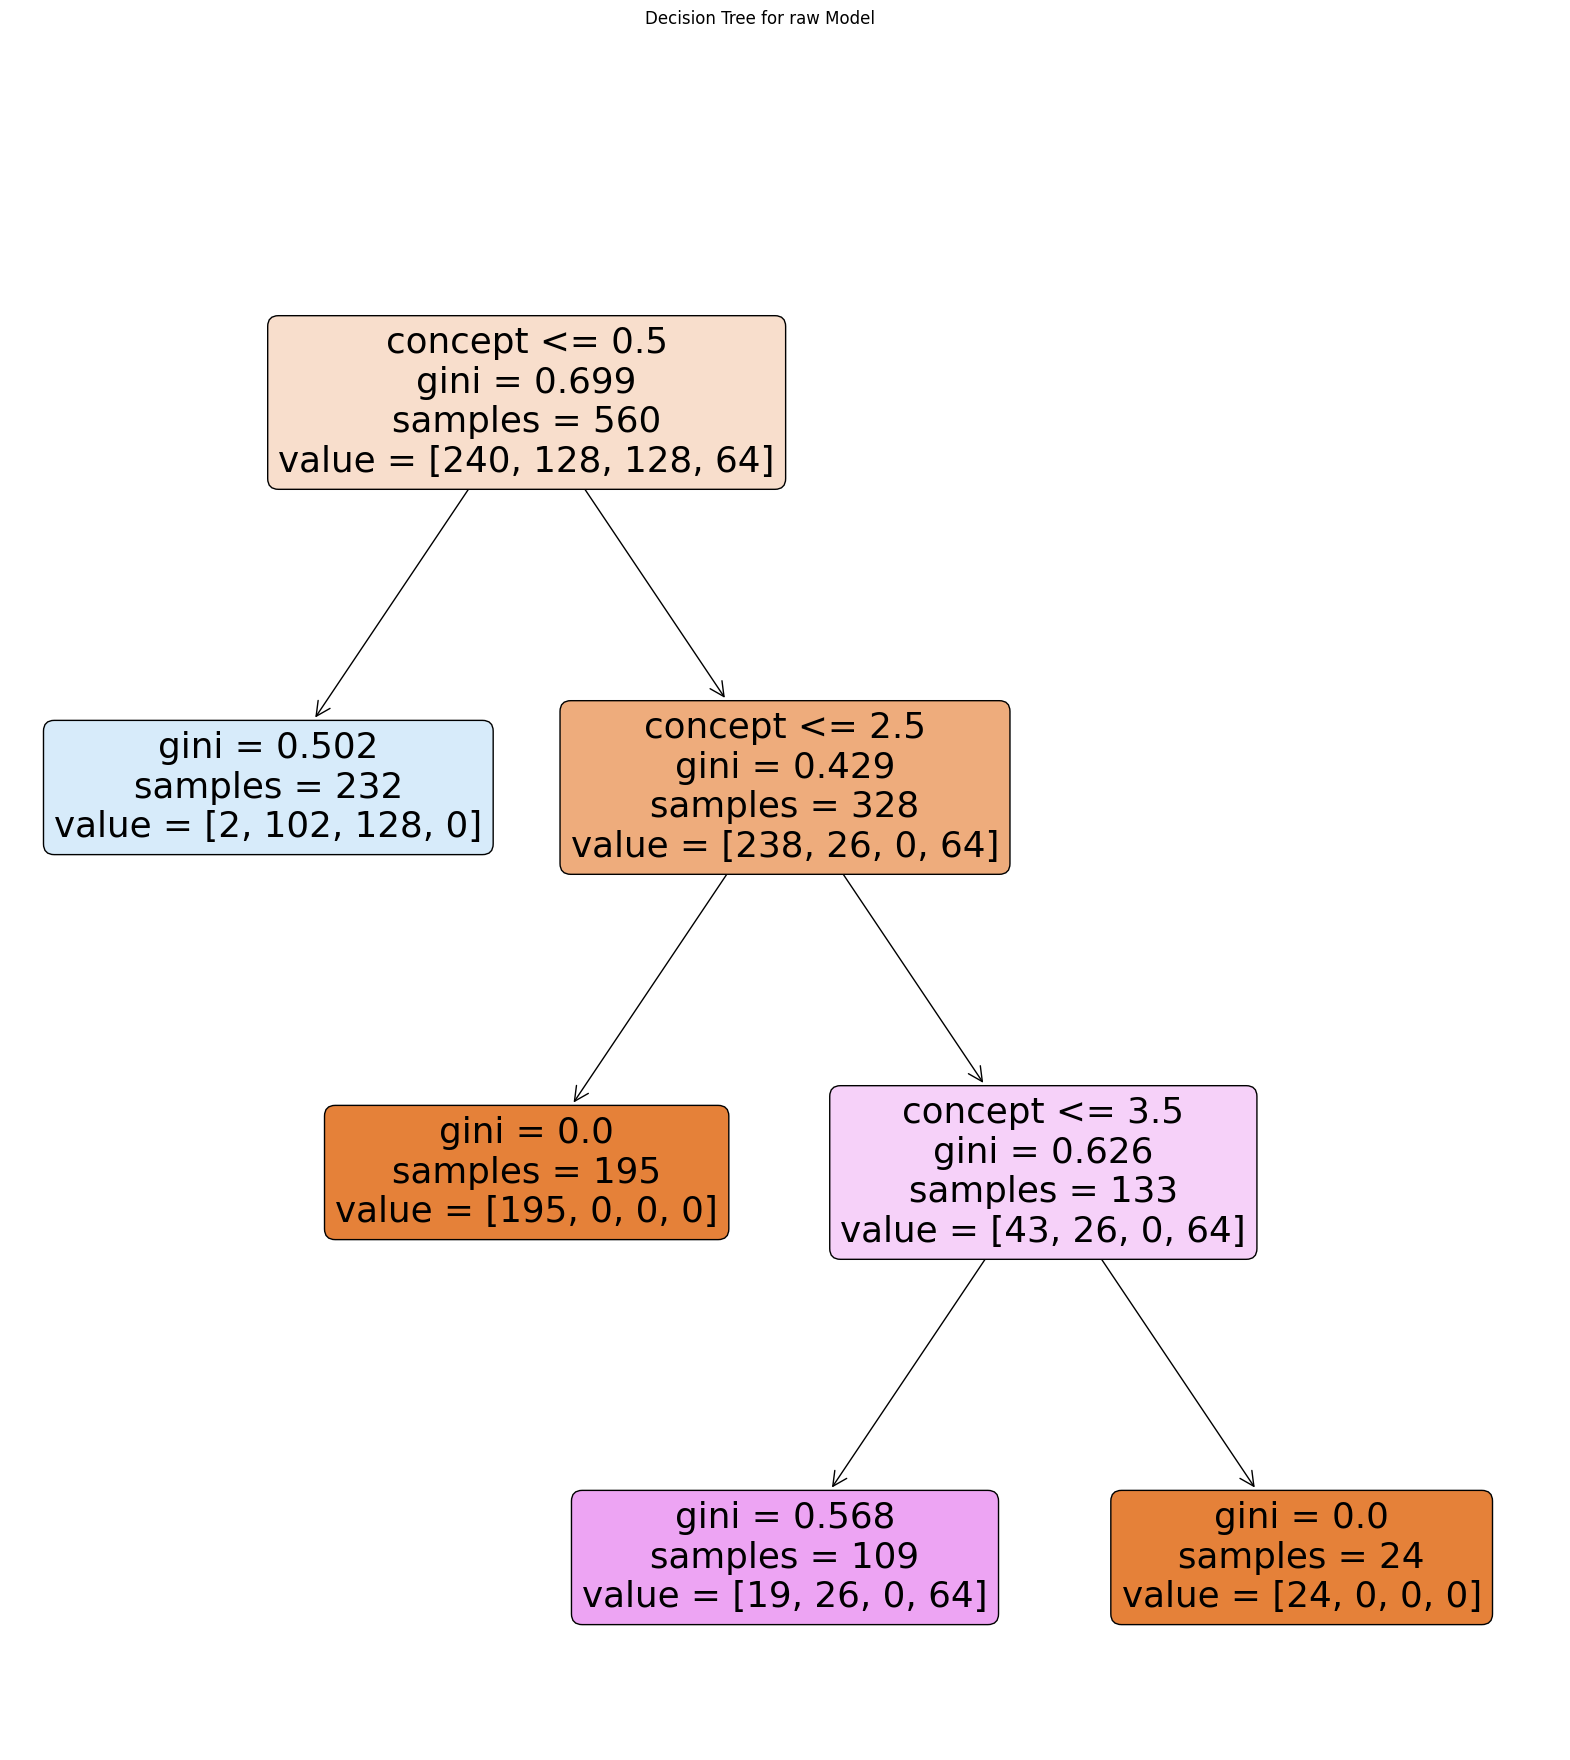

4   0.7214285714285714


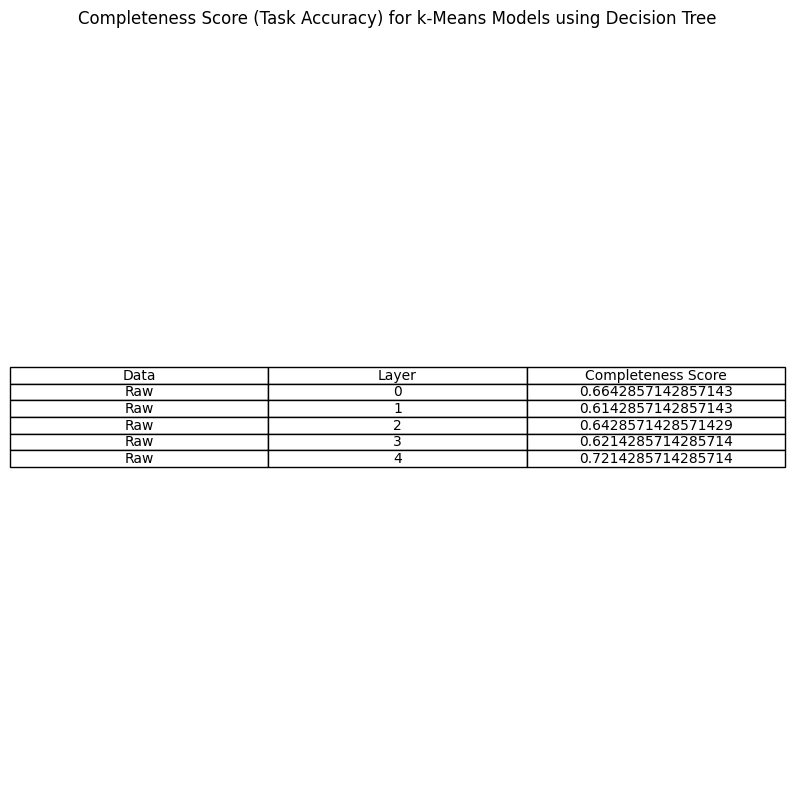

In [ ]:
################################################################################
# [5.] Activation to Concept to Class with k-Means =============================
################################################################################
import seaborn as sn
import sklearn.metrics as metrics
from sklearn import tree, linear_model

class ActivationClassifier():

    def __init__(self,
                 pred_data: np.ndarray,
                 clustering_model,
                 classifier_type: str,
                 x: torch.Tensor,
                 y: torch.Tensor,
                 train_mask: torch.Tensor=None,
                 test_mask: torch.Tensor=None,
                 if_graph_class: bool=False):
        """
        Classifier that will use all data belonging to one cluster/concept

        :param pred_data: Activation from layer output
        :param clustering_model: ML model of clustering (f.e. K-Means)
        :param classifier_type: Description of the classifier
                                (f.e. "decision tree")
        :param x: Features of nodes
        :param y: Labels of nodes
        :param train_mask: Tensor that contains True in the indexes for
                           the training data and False in the indexes for
                           the test data
        :param test_mask: Tensor that contains True in the indexes for
                          the test data and False in the indexes for
                          the training data
        :param if_graph_class: Boolean variable that is true in the cases
                               of graph classification
        """

        self.pred_data = pred_data
        self.clustering_model = clustering_model
        self.classifier_type = classifier_type

        if if_graph_class:
            self.dataloader = x
            self.y = y
            self.train_mask = np.zeros(len(y))
            self.train_mask[:int(len(train_mask) * 0.8)] = 1
            self.test_mask = ~self.train_mask
        else:
            self.x = x.detach().numpy()
            self.y = y.detach().numpy()
            self.train_mask = train_mask
            self.test_mask = test_mask

        self.if_graph_class = if_graph_class

        # Call the training method depending on the clustering model -----------
        if isinstance(self.clustering_model, AgglomerativeClustering) or \
           isinstance(self.clustering_model, DBSCAN):
            self.y_hc = self.clustering_model.fit_predict(self.pred_data)

        self.classifier, self.accuracy = self._train_classifier()

    def _train_classifier(self):
        """
        Train the classifier
        """

        # Depending if the node is in the training or the test set, ------------
        # append the activation in a different list ----------------------------
        # to create the training and test set of the activations ---------------
        self.train_concepts = []
        self.test_concepts = []

        for node_idx in range(len(self.train_mask)):
            if self.train_mask[node_idx] == 1:
                self.train_concepts.append([self.activation_to_concept(node_idx)])
            else:
                self.test_concepts.append([self.activation_to_concept(node_idx)])

        # Depending on the classifier call the training/fit method -------------
        if self.classifier_type == 'decision_tree':
            cls = tree.DecisionTreeClassifier()
            cls = cls.fit(self.train_concepts, self.y[self.train_mask])

        elif self.classifier_type == 'logistic_regression':
            cls = linear_model.LogisticRegression(multi_class='ovr',
                                                  max_iter=1000,
                                                  penalty='l1',
                                                  solver='liblinear')
            cls = cls.fit(self.train_concepts, self.y[self.train_mask])

        # Return the trained classifier and its accuracy -----------------------
        accuracy = cls.score(self.test_concepts, self.y[self.test_mask])

        return cls, accuracy

    def get_classifier_accuracy(self):
        """
        Return the accuracy of the classifier
        """

        return self.accuracy

    def _activation_to_cluster(self, node: int):
        """
        Use the clustering model (f.e.) to check on which cluster the node
        will be assigned (belong) to.

        :param node: Node index
        """

        if isinstance(self.clustering_model, KMeans):
            cluster = self.clustering_model.predict(self.pred_data)
            cluster = cluster[node]

        elif isinstance(self.clustering_model, AgglomerativeClustering) \
          or isinstance(self.clustering_model, DBSCAN):
            cluster = np.array(self.y_hc[node])

        return cluster

    def _cluster_to_concept(self, cluster: np.int32):
        """
        Selection of cluster/concept by index

        :param cluster: Index of cluster
        """

        concept = cluster

        return concept

    def activation_to_concept(self, node: int):
        """
        Get the cluster on which the node "belongs" to

        :param node: Node index
        """


        # Get cluster for node -------------------------------------------------
        cluster = self._activation_to_cluster(node)

        # Return cluster number as substitute of concept -----------------------
        concept = self._cluster_to_concept(cluster)

        return concept

    def concept_to_class(self, concept):
        """
        After the classifier is trained, all nodes belong to a concept
        can be classified. This method computes and returns the class
        to which they are classified to.

        :param concept:
        """

        concept = concept.reshape(1, -1)
        pred = self.classifier.predict(concept)

        return pred

    def plot(self, layer_num: int, k: int, reduction_type: str):
        """
        Plot the results of the classification; for the decision tree
        it is the tree of the learned rules.


        :param layer_num: Number of layer
        :param k: Number of clusters
        :param reduction_type: "raw" since those data are not further
                               dimensionality reducted
        """

        if self.classifier_type == 'decision_tree':

            fig, ax = plt.subplots(figsize=(20, 20))
            tree.plot_tree(self.classifier,
                           filled=True,
                           rounded=True,
                           feature_names=["concept"],
                           ax=ax)
            fig.suptitle(f"Decision Tree for {reduction_type} Model")

        elif self.classifier_type == 'logistic_regression':

            fig, ax = plt.subplots(figsize=(6, 6))
            pred = self.classifier.predict(self.test_concepts)
            ls = np.unique(self.y)
            confusion_matrix = metrics.confusion_matrix(self.y[self.test_mask],
                                                        pred,
                                                        labels=ls)
            cm = pd.DataFrame(confusion_matrix, index=ls, columns=ls)

            ax = sn.heatmap(cm, annot=True, cmap="YlGnBu", ax=ax, fmt='g', )
            fig.suptitle(f"Confusion Matrix of Logistic Regression on for " + \
                         f"{reduction_type} Model")
            ax.set_xlabel("Target Class")
            ax.set_ylabel("Predicted Class")

        plt.show()
        plt.close()

def plot_completeness_table(clustering_type_name: str,
                            calc_type: str,
                            completeness_scores: list):
    """
    Create a table with the completeness score - performance of an individual
    classifier that is trained with the activations of each layer.

    :param clustering_type_name: Name of the clustering type (K-Means)
    :param calc_type: Description of the new classifier ("decision tree")
    :param completeness_scores: List of the completeness scores for each layer
    """

    fig, ax = plt.subplots(figsize=(10, 2 * len(completeness_scores)))
    headings = ["Data", "Layer", "Completeness Score"]

    ax.set_title(f"Completeness Score (Task Accuracy) for " +
                 f"{clustering_type_name} Models using {calc_type}")
    ax.axis('off')
    ax.table(cellText=completeness_scores, colLabels=headings, loc="center",
             rowLoc="center", cellLoc="center", colLoc="center", fontsize=18)

    calc_type = calc_type.replace(" ", "")
    plt.show()
    plt.close()

# [5.1.] Define the classifier for the computation of completeness -------------
classifier_str = "decision_tree"

# Gather list of completeness scores -------------------------------------------
completeness_scores = []

# [5.2.] Iterate over all activations of all layers ----------------------------
for i, key in enumerate(gcn_model_activation_dict):

    activation = torch.squeeze(gcn_model_activation_dict[key]).detach().numpy()

    # [5.3.] Classifier on the activations -------------------------------------
    activation_cls = ActivationClassifier(activation,
                                          raw_kmeans_models[i],
                                          classifier_str,
                                          graph_ba_shapes["x"],
                                          graph_ba_shapes["y"],
                                          graph_ba_shapes["train_mask"],
                                          graph_ba_shapes["test_mask"])

    # [5.4.] Get the accuracy as an indication of performance that is a "proxy"
    # (for the purposes of this excercise equals) to the completeness ----------
    classifier_performance = \
     ["Raw", str(i), str(activation_cls.get_classifier_accuracy())]
    completeness_scores.append(classifier_performance)
    activation_cls.plot(i, k, "raw")
    print(i, " ", activation_cls.get_classifier_accuracy())

    # Plot the completeness table for each layer of the GNN --------------------
    plot_completeness_table("k-Means", "Decision Tree",
                            completeness_scores)




In [ ]:
################################################################################
# [6.] Graph similarity ========================================================
################################################################################

graph_scores = []
view = 3
max_num_nodes = 15

def calc_graph_similarity(top_graphs: list,
                          max_nodes: int,
                          num_nodes_view: int):
    """
    Compute the Graph Edit Distance (GED) between all graphs in the
    inpute graph list.

    :param top_graphs: List of graphs to compute the GED on
    :param max_nodes: Threshold of the number of nodes in the graph
                      for processing
    :param num_nodes_view: Unused parameter for teh GED computation
    """

    top_G = top_graphs[0]

    print("Nodes ", top_G.number_of_nodes(), " Graphs ", len(top_graphs))

    # Apply threshold ----------------------------------------------------------
    if top_G.number_of_nodes() > max_nodes:
        return "skipping (too many nodes)"

    if_iso = True

    # Check for isomorphism - if they are the GED is 0 -------------------------
    for G in top_graphs[1:]:
        if not nx.is_isomorphic(top_G, G):
            if_iso = False
            break

    if if_iso:
        return 0

    # Use the networkx GED method to compute the distance metric ---------------
    total_score = 0
    for G in top_graphs[1:]:

        if G.number_of_nodes() > max_nodes:
            return "skipping (too many nodes)"

        total_score += min(list(nx.optimize_graph_edit_distance(top_G, G)))

    return total_score / (len(top_graphs) - 1)

# Iterate over all activations -------------------------------------------------
for i, key in enumerate(gcn_model_activation_dict):

    # Compute the activations and the GED distances ----------------------------
    activation = torch.squeeze(gcn_model_activation_dict[key]).detach().numpy()
    distances = get_node_distances(raw_kmeans_models[i], activation)

    # Iterate over each cluster ------------------------------------------------
    for k_idx in range(k):

        # Get the top clusters and their graph similarity ----------------------
        top_indices = np.argsort(distances[:, k_idx])[::][:view]
        top_graphs, _, _, _ = get_top_subgraphs(top_indices,
                                                graph_ba_shapes['y'],
                                                edges, num_expansions)

        score = calc_graph_similarity(top_graphs, max_num_nodes, view)
        print(score)

        # Append the score and further information to a list -------------------
        information_score = ["k-Means", "raw", str(i), str(k_idx), str(score)]
        graph_scores.append(information_score)

    # Plot the graphs ----------------------------------------------------------
    plot_samples(raw_kmeans_models[i], activation, graph_ba_shapes['y'],
                 i, k, "k-Means", "raw", view, edges, num_expansions)

    print("-------------------------------------------------------------------")



Nodes  11  Graphs  3


KeyboardInterrupt: 